In [ ]:
# ===========================================
# macro data pretrain
# ===========================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset
import joblib


df = pd.read_csv("macro.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

# 결측: forward-only로 (누수 방지)
df = df.ffill().interpolate(limit_direction="forward")

# 변환
df_tr = pd.DataFrame({
    "PMI": df["PMI"],
    "GS10": df["GS10"],
    "LOG_M2": np.log(df["M2SL"]),
    "UNRATE": df["UNRATE"],
    "INFLATION": np.log(df["CPIAUCSL"]).diff(),
    "LOG_INDPRO": np.log(df["INDPRO"]),
}, index=df.index).dropna()

# ===== time split 먼저 =====
T = len(df_tr)
n_train = int(T * 0.8)
n_val   = int(T * 0.1)
train_df = df_tr.iloc[:n_train]
val_df   = df_tr.iloc[n_train:n_train+n_val]
test_df  = df_tr.iloc[n_train+n_val:]

# ===== scaler는 train에만 fit =====
scaler = StandardScaler()
train_np = scaler.fit_transform(train_df.values)
val_np   = scaler.transform(val_df.values)
test_np  = scaler.transform(test_df.values)

joblib.dump(scaler, "macro_scaler.pkl")

class MacroDataset(Dataset):
    def __init__(self, data_np, L=36, H=12):
        self.data = torch.from_numpy(data_np).float()  # (T, 6)
        self.L, self.H = L, H

    def __len__(self):
        return len(self.data) - (self.L + self.H) + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.L]                      # (L, 6)
        y = self.data[idx+self.L:idx+self.L+self.H]        # (H, 6)
        x = x.transpose(0, 1).contiguous()                 # (6, L)
        return x, y

L, H = 36, 12
train_ds = MacroDataset(train_np, L, H)
val_ds   = MacroDataset(val_np, L, H)
test_ds  = MacroDataset(test_np, L, H)

print(len(train_ds), len(val_ds), len(test_ds))


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

###############################################
#  1) TCN Building Blocks (이미 위에 있음)
###############################################
from torch.nn.utils import weight_norm

def kl_gaussian(mu, logvar):
    """
    KL( N(mu, sigma^2) || N(0, I) ), diag 가정
    mu: (B, latent_dim)
    logvar: (B, latent_dim)
    """
    # sigma^2 = exp(logvar)
    # 공식: 0.5 * Σ( exp(logvar) + mu^2 - 1 - logvar )
    return 0.5 * torch.mean(
        torch.sum(
            torch.exp(logvar) + mu**2 - 1.0 - logvar,
            dim=1
        )
    )


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        if self.chomp_size == 0:
            return x
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs,
                 kernel_size, dilation, dropout=0.15):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = weight_norm(
            nn.Conv1d(
                n_inputs,
                n_outputs,
                kernel_size,
                padding=padding,
                dilation=dilation,
            )
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(
            nn.Conv1d(
                n_outputs,
                n_outputs,
                kernel_size,
                padding=padding,
                dilation=dilation,
            )
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(n_inputs, n_outputs, 1)
            if n_inputs != n_outputs
            else None
        )
        self.relu = nn.ReLU()

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.drop2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels,
                 kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers.append(
                TemporalBlock(
                    n_inputs=in_ch,
                    n_outputs=out_ch,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout,
                )
            )
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

###############################################
#  2) MacroEncoder + Forecast Head
###############################################

class MacroEncoder(nn.Module):
    """
    Macro-only Encoder for pretraining.
    x: (B, F=6, L=36)  ->  z: (B, latent_dim)
    """
    def __init__(self, input_dim=6, hidden_dim=128, latent_dim=32,
                 num_layers=4, kernel_size=3, dropout=0.15):
        super().__init__()

        # 1) input projection: F -> hidden
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, kernel_size=1)

        # 2) TCN backbone (hidden -> hidden)
        self.tcn = TemporalConvNet(
            num_inputs=hidden_dim,
            num_channels=[hidden_dim] * num_layers,
            kernel_size=kernel_size,
            dropout=dropout,
        )

        # 3) Latent heads
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        """
        x: (B, F, L)
        """
        h = self.input_proj(x)       # (B, hidden, L)
        h = self.tcn(h)              # (B, hidden, L)
        h_last = h[:, :, -1]         # (B, hidden)

        mu = self.fc_mu(h_last)
        logvar = self.fc_logvar(h_last)
        return mu, logvar


class MacroForecastModel(nn.Module):
    """
    Encoder + 작은 Forecast Head
    - Encoder는 VAE-style latent를 뽑고
    - Head가 미래 H 스텝 전체를 예측
    """
    def __init__(self, input_dim=6, hidden_dim=128, latent_dim=32,
                 num_layers=4, kernel_size=3, dropout=0.15, H=12):
        super().__init__()
        self.encoder = MacroEncoder(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            num_layers=num_layers,
            kernel_size=kernel_size,
            dropout=dropout,
        )
        self.latent_dim = latent_dim
        self.H = H
        self.input_dim = input_dim
        
        # Forecast head: z -> future window (H * F)
        self.head = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, H * input_dim),
        )

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        std = torch.exp(0.5 * logvar)
        return mu + eps * std

    def forward(self, x):
        """
        x: (B, F, L)
        return:
          y_pred: (B, H, F)
          mu, logvar, z
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        out = self.head(z)                         # (B, H*F)
        y_pred = out.view(-1, self.H, self.input_dim)  # (B, H, F)
        return y_pred, mu, logvar, z


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def train_macro_pretrain(
    train_ds,
    val_ds,
    input_dim=6,
    latent_dim=32,
    hidden_dim=128,
    H=12,
    lr=1e-3,
    batch_size=32,
    epochs=80,
    beta_max=0.01,    # KL weight (작게 하는 게 안정적)
    warmup_ratio=0.2,
    device="cuda" if torch.cuda.is_available() else "cpu"
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = MacroForecastModel(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        H=H,
    ).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # history 기록
    history = {
        "tr_loss": [], "tr_mse": [], "tr_kl": [],
        "va_loss": [], "va_mse": [], "va_kl": [],
        "beta": []
    }

    warmup_epochs = int(epochs * warmup_ratio)

    print("===== MACRO PRETRAIN (with Validation) =====")
    for epoch in range(1, epochs+1):

        # --------- KL Annealing ---------
        if epoch <= warmup_epochs:
            beta = 0.0
        else:
            t = (epoch - warmup_epochs) / (epochs - warmup_epochs)
            beta = beta_max * min(1.0, t)
        history["beta"].append(beta)

        # ───────────────────────────────────
        #              TRAIN
        # ───────────────────────────────────
        model.train()
        total_loss=total_mse=total_kl=0
        n=0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            y_pred, mu, logvar, _ = model(xb)
            mse = F.mse_loss(y_pred, yb)
            kl  = kl_gaussian(mu, logvar)
            loss = mse + beta * kl

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss.item() * xb.size(0)
            total_mse  += mse.item()  * xb.size(0)
            total_kl   += kl.item()   * xb.size(0)
            n += xb.size(0)

        tr_loss = total_loss/n
        tr_mse  = total_mse/n
        tr_kl   = total_kl/n

        history["tr_loss"].append(tr_loss)
        history["tr_mse"].append(tr_mse)
        history["tr_kl"].append(tr_kl)

        # ───────────────────────────────────
        #             VALIDATION
        # ───────────────────────────────────
        model.eval()
        total_loss=total_mse=total_kl=0
        n=0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)

                y_pred, mu, logvar, _ = model(xb)
                mse = F.mse_loss(y_pred, yb)
                kl  = kl_gaussian(mu, logvar)
                loss = mse + beta * kl

                total_loss += loss.item() * xb.size(0)
                total_mse  += mse.item()  * xb.size(0)
                total_kl   += kl.item()   * xb.size(0)
                n += xb.size(0)

        va_loss = total_loss/n
        va_mse  = total_mse/n
        va_kl   = total_kl/n

        history["va_loss"].append(va_loss)
        history["va_mse"].append(va_mse)
        history["va_kl"].append(va_kl)

        print(f"[{epoch:03d}/{epochs}] "
              f"TR Loss={tr_loss:.4f} MSE={tr_mse:.4f} KL={tr_kl:.4f} | "
              f"VAL Loss={va_loss:.4f} MSE={va_mse:.4f} KL={va_kl:.4f} | "
              f"beta={beta:.4f}")

    return model, history



model, history = train_macro_pretrain(
    train_ds,
    val_ds,
    input_dim=6,
    latent_dim=32,
    hidden_dim=128,
    H=12,
    epochs=80,
)

torch.save(model.encoder.state_dict(), "macro_encoder.pth")
print("Saved macro_encoder.pth")


import matplotlib.pyplot as plt

epochs = range(1, len(history["tr_loss"]) + 1)

# ----- Total Loss -----
plt.figure(figsize=(8,4))
plt.plot(epochs, history["tr_loss"], label="Train")
plt.plot(epochs, history["va_loss"], label="Val")
plt.title("Total Loss")
plt.legend(); plt.show()

# ----- MSE -----
plt.figure(figsize=(8,4))
plt.plot(epochs, history["tr_mse"], label="Train")
plt.plot(epochs, history["va_mse"], label="Val")
plt.title("MSE")
plt.legend(); plt.show()

# ----- KL -----
plt.figure(figsize=(8,4))
plt.plot(epochs, history["tr_kl"], label="Train")
plt.plot(epochs, history["va_kl"], label="Val")
plt.title("KL Divergence")
plt.legend(); plt.show()

# ----- Beta -----
plt.figure(figsize=(6,3))
plt.plot(epochs, history["beta"])
plt.title("KL Annealing")
plt.show()



import torch
from torch.utils.data import DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_latents(model, dataset, device=device):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()
    zs = []

    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            mu, logvar = model.encoder(xb)
            zs.append(mu.cpu().numpy())

    return np.concatenate(zs, axis=0)   # (N, latent_dim)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

z = extract_latents(model, train_ds, device=device)
pca = PCA(n_components=2)
z2 = pca.fit_transform(z)

plt.figure(figsize=(7,6))
plt.scatter(z2[:,0], z2[:,1], c=np.arange(len(z2)), cmap="viridis", s=12)
plt.title("Latent Space (PCA) - Time Gradient")
plt.colorbar(label="Time →")
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(z2[:,0], z2[:,1], c=train_df["PMI"].values[:len(z2)], cmap="plasma", s=12)
plt.title("Latent Space Colored by PMI")
plt.colorbar(label="PMI")
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(z2[:,0], z2[:,1], c=train_df["UNRATE"].values[:len(z2)], cmap="coolwarm", s=12)
plt.title("Latent Space Colored by UNRATE")
plt.colorbar(label="UNRATE (%)")
plt.show()

recessions = [
    ("2001-03-01", "2001-11-01"),
    ("2007-12-01", "2009-06-01"),
    ("2020-02-01", "2020-04-01")
]

# recession mask
mask = np.zeros(len(train_df), dtype=bool)
for start, end in recessions:
    mask |= (train_df.index >= start) & (train_df.index <= end)

plt.figure(figsize=(7,6))
plt.scatter(z2[:,0], z2[:,1], c=mask[:len(z2)], cmap="bwr", s=12)
plt.title("Latent Space Highlighting Recessions")
plt.show()


488 19 21
===== MACRO PRETRAIN (with Validation) =====


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[001/80] TR Loss=0.7879 MSE=0.7879 KL=55.7419 | VAL Loss=0.5042 MSE=0.5042 KL=251.5765 | beta=0.0000
[002/80] TR Loss=0.4111 MSE=0.4111 KL=121.4389 | VAL Loss=0.3396 MSE=0.3396 KL=190.5218 | beta=0.0000
[003/80] TR Loss=0.3300 MSE=0.3300 KL=108.0455 | VAL Loss=0.3898 MSE=0.3898 KL=158.2332 | beta=0.0000
[004/80] TR Loss=0.2768 MSE=0.2768 KL=121.0342 | VAL Loss=0.3323 MSE=0.3323 KL=168.8555 | beta=0.0000
[005/80] TR Loss=0.2444 MSE=0.2444 KL=123.0593 | VAL Loss=0.2331 MSE=0.2331 KL=228.2247 | beta=0.0000
[006/80] TR Loss=0.2279 MSE=0.2279 KL=127.0437 | VAL Loss=0.2343 MSE=0.2343 KL=206.1403 | beta=0.0000
[007/80] TR Loss=0.2090 MSE=0.2090 KL=124.8814 | VAL Loss=0.2144 MSE=0.2144 KL=231.8546 | beta=0.0000
[008/80] TR Loss=0.1989 MSE=0.1989 KL=132.3100 | VAL Loss=0.2015 MSE=0.2015 KL=208.9525 | beta=0.0000
[009/80] TR Loss=0.1884 MSE=0.1884 KL=130.8110 | VAL Loss=0.1777 MSE=0.1777 KL=220.5101 | beta=0.0000
[010/80] TR Loss=0.1768 MSE=0.1768 KL=134.7594 | VAL Loss=0.1828 MSE=0.1828 KL=227.

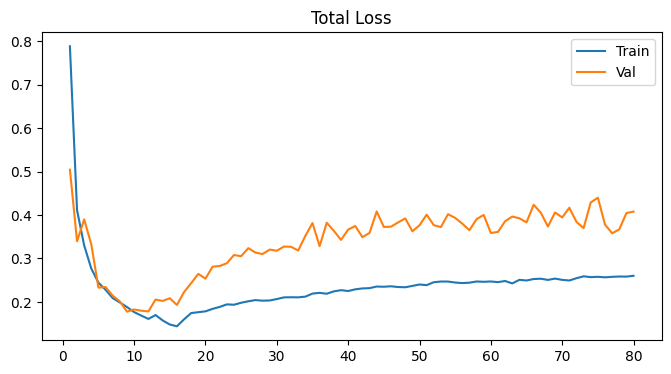

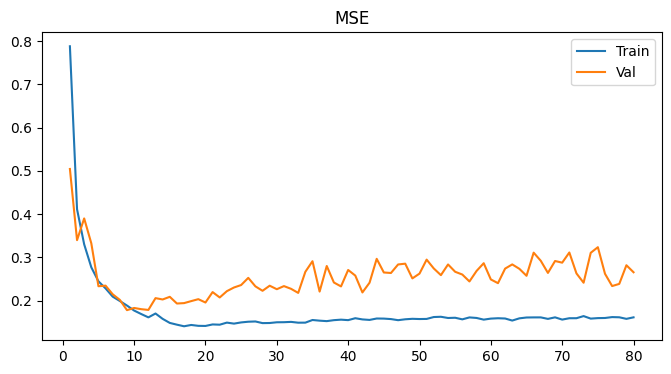

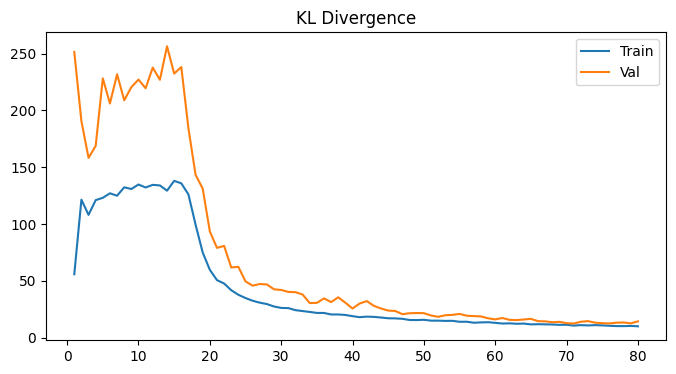

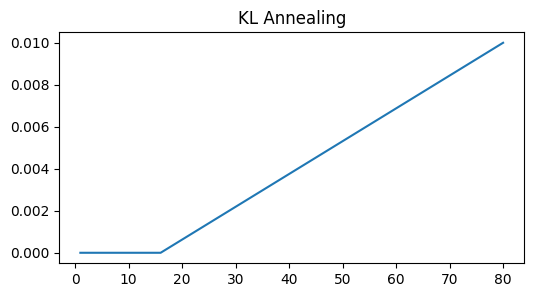

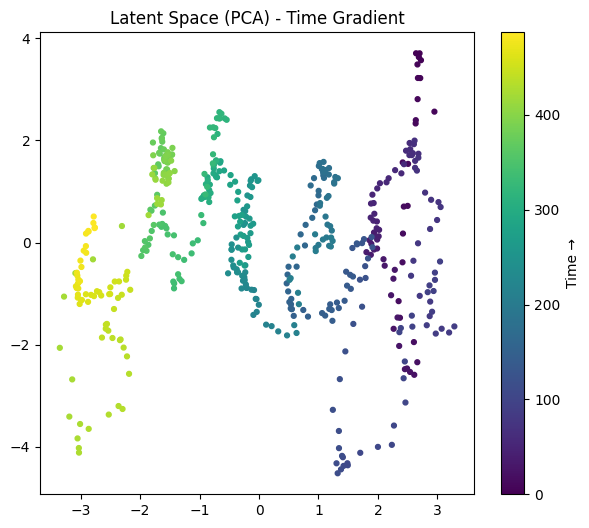

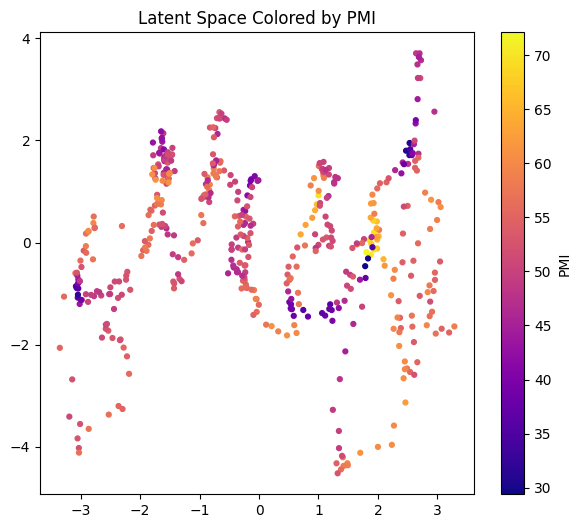

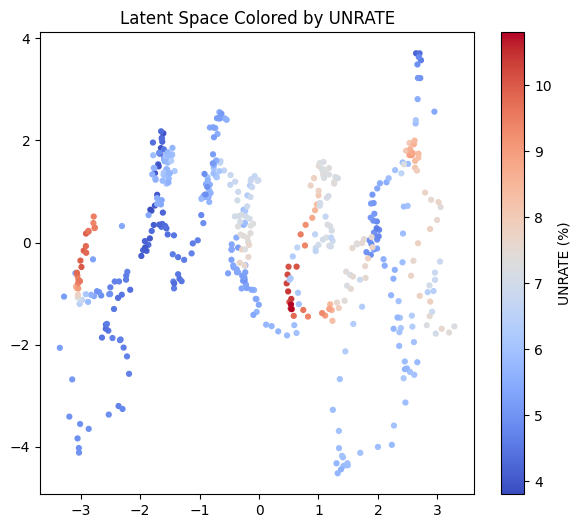

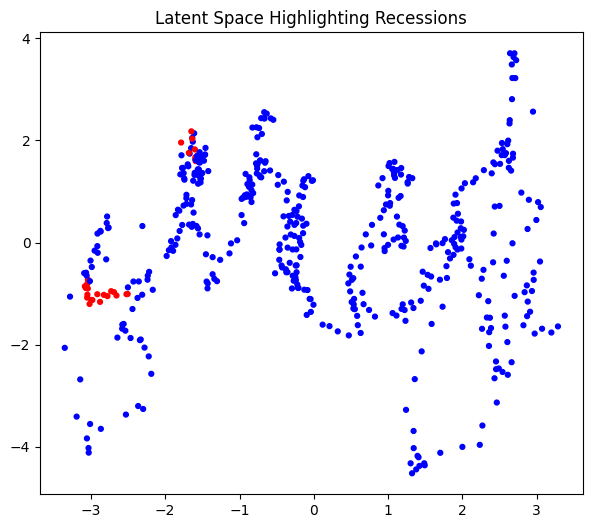

In [ ]:
# ===========================================
# (Dataset + Preprocessing + Training + Backtests)
# ===========================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

from model import Encoder, Decoder, ConditionalPrior, TimeVAE
from macro_pretrain import MacroEncoder


# -------------------------------
# Dataset
# -------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y, c):
        self.x = x
        self.y = y
        self.c = c

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.c[idx]
    
# -------------------------------
# Create Dataset (Sliding Window)
# -------------------------------
def create_dataset(df_scaled: pd.DataFrame, L: int, H: int, cond_cols):
    X, Y, C = [], [], []
    total_len = len(df_scaled)

    # +1 포함이 보통 정석 (마지막 가능한 window 포함)
    for start in range(total_len - L - H + 1):
        end_x = start + L
        end_y = end_x + H

        x = df_scaled.iloc[start:end_x].to_numpy(dtype=np.float32)  # (L,D)
        y = df_scaled.iloc[end_x:end_y].to_numpy(dtype=np.float32)  # (H,D)
        c = df_scaled.iloc[end_x - 1][cond_cols].to_numpy(dtype=np.float32)  # (cond_dim,)

        X.append(x)
        Y.append(y)
        C.append(c)

    return np.asarray(X, dtype=np.float32), np.asarray(Y, dtype=np.float32), np.asarray(C, dtype=np.float32)


def _read_csv_with_date_index(csv_path: str, encoding: str, date_col: str = "Date") -> pd.DataFrame:
    df = pd.read_csv(csv_path, encoding=encoding)
    if date_col not in df.columns:
        raise ValueError(f"'{date_col}' column not found in {csv_path}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()
    return df


def _coerce_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    # 콤마(1,388.90) / 공백 / 문자열 등 안전 처리
    out = df.copy()
    for col in out.columns:
        out[col] = pd.to_numeric(
            out[col].astype(str).str.replace(",", "").str.strip(),
            errors="coerce",
        )
    return out


def preprocess(
    csv_path: str,
    macro_csv_path: str,
    condition_raw_cols,
    macro_cols,
    L: int,
    H: int,
    *,
    semi_encoding: str = "latin1",
    macro_encoding: str = "utf-8-sig",
    drop_semi_cols=("PMI",),        # 반도체쪽 PMI 제거 기본값 유지
    capex_col: str = "CAPEX",
    fill_strategy: str = "ffill_bfill",  # "zero" or "ffill_bfill"
):
    """
    csv_path: 반도체 데이터 csv
    macro_csv_path: 매크로 데이터 csv
    condition_raw_cols: TimeVAE condition용 컬럼 리스트
    macro_cols: macro encoder가 보는 macro 컬럼 리스트
    """

    # 1) Load
    df_semi = _read_csv_with_date_index(csv_path, encoding=semi_encoding)
    df_macro = _read_csv_with_date_index(macro_csv_path, encoding=macro_encoding)

    # 2) Select macro cols (없으면 에러 내서 빨리 잡기)
    missing_macro = [c for c in macro_cols if c not in df_macro.columns]
    if missing_macro:
        raise ValueError(f"macro_csv is missing columns: {missing_macro}")
    df_macro = df_macro[macro_cols].copy()

    # 3) Optional: drop semi cols
    for col in drop_semi_cols:
        if col in df_semi.columns:
            df_semi = df_semi.drop(columns=[col])

    # 4) Merge by index (Date)
    df_merged = df_semi.join(df_macro, how="inner")
    df_raw = df_merged.copy()  # raw 저장(시각화/리포팅용)

    # 5) Numeric conversion (콤마/문자열 포함 안전 처리)
    df_merged = _coerce_numeric_df(df_merged)

    # 6) CAPEX log1p (0/음수 방어)
    if capex_col in df_merged.columns:
        # 음수 있으면 log1p가 NaN 되니까, 최소 0으로 클립(원하면 다른 방식 가능)
        cap = df_merged[capex_col].to_numpy()
        cap = np.clip(cap, a_min=0.0, a_max=None)
        df_merged[capex_col] = np.log1p(cap)

    # 7) Missing handling
    # condition/macro는 0으로 고정하는 기존 정책 유지 + 전체 fill 전략
    for col in condition_raw_cols:
        if col not in df_merged.columns:
            raise ValueError(f"condition column not found after merge: {col}")
    df_merged[condition_raw_cols] = df_merged[condition_raw_cols].fillna(0.0)

    df_merged[macro_cols] = df_merged[macro_cols].fillna(0.0)

    if fill_strategy == "ffill_bfill":
        df_merged = df_merged.ffill().bfill()
        df_merged = df_merged.fillna(0.0)  # 끝까지 남는 NaN 방어
    elif fill_strategy == "zero":
        df_merged = df_merged.fillna(0.0)
    else:
        raise ValueError("fill_strategy must be 'ffill_bfill' or 'zero'")

    # 8) Scaling (DataFrame 유지: feature name 경고 방지 + 순서 안전)
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_merged),
        index=df_merged.index,
        columns=df_merged.columns,
    )

    # 9) macro feature indices
    macro_feature_indices = [df_scaled.columns.get_loc(col) for col in macro_cols]

    # 10) Sliding windows
    X, Y, C = create_dataset(df_scaled, L, H, condition_raw_cols)

    print("X shape:", X.shape)  # (N,L,D)
    print("Y shape:", Y.shape)  # (N,H,D)
    print("C shape:", C.shape)  # (N,cond_dim)
    print("macro_feature_indices:", macro_feature_indices)

    return X, Y, C, scaler, df_raw, df_scaled, macro_feature_indices



# -------------------------------
# Training
# -------------------------------
def train_model(
     X_train, Y_train, C_train,
    latent_dim, cond_dim, hidden,
    H_len, beta, lr, epochs, batch_size, device,
    macro_feature_indices,
    macro_latent_dim=32,
    macro_hidden_dim=128,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_dim = X_train.shape[-1]

    train_dataset = TimeSeriesDataset(X_train, Y_train, C_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 1) Pretrained MacroEncoder 로드 (input_dim = len(macro_feature_indices))
    macro_input_dim = len(macro_feature_indices)
    macro_encoder = MacroEncoder(
        input_dim=macro_input_dim,
        hidden_dim=macro_hidden_dim,
        latent_dim=macro_latent_dim
    ).to(device)
    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    
    # 2) TimeVAE 구성
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H_len).to(device)
    prior = ConditionalPrior(
        cond_dim,
        macro_latent_dim=macro_latent_dim,
        latent_dim=latent_dim,
        hidden=hidden
    ).to(device)


    model = TimeVAE(
        encoder, decoder, prior,
        macro_encoder=macro_encoder,
        latent_dim=latent_dim,
        beta=beta
    ).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("======== Training start ========")
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        epoch_recon = 0.0
        epoch_kl = 0.0
        num_batches = 0

        for x, y, c in train_loader:
            x, y, c = x.to(device), y.to(device), c.to(device)

            # macro_x: (B, macro_dim, L)
            macro_x = x[:, :, macro_feature_indices]      # (B, L, macro_dim)
            macro_x = macro_x.permute(0, 2, 1)           # (B, macro_dim, L)

            loss, recon, kl, _, _, _ = model(
                x, c, macro_x, y,
                use_prior_sampling_if_no_y=False
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon += recon.item()
            epoch_kl += kl.item()
            num_batches += 1

        print(
            f"[Epoch {epoch}/{epochs}] "
            f"Loss: {epoch_loss/num_batches:.4f} | "
            f"Recon: {epoch_recon/num_batches:.4f} | "
            f"KL: {epoch_kl/num_batches:.4f}"
        )

    torch.save(model.state_dict(), "timevae_ctvae_prior.pth")
    print("Saved model → timevae_ctvae_prior.pth")
    return model


# ======================================================================
# 1) Rolling Backtest (고정 모델로 1-step Forecast)
# ======================================================================

def rolling_backtest( model_path, X, Y, C,
    latent_dim, cond_dim, hidden, H, beta,
    macro_feature_indices,
    macro_latent_dim=32,
    macro_hidden_dim=128,
    device="cuda"
    ):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_dim = X.shape[-1]

    # Pretrained MacroEncoder 로드
    macro_input_dim = len(macro_feature_indices)
    macro_encoder = MacroEncoder(
        input_dim=macro_input_dim,
        hidden_dim=macro_hidden_dim,
        latent_dim=macro_latent_dim
    ).to(device)
    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    # 모델 구성 & 가중치 로드
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
    prior = ConditionalPrior(
        cond_dim, macro_latent_dim,
        latent_dim, hidden
    ).to(device)

    model = TimeVAE(encoder, decoder, prior, macro_encoder, latent_dim, beta).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    mses = []

    # 모든 시점에서 고정 모델로 예측
    for t in range(len(X)):
        x = torch.tensor(X[t:t+1]).float().to(device)
        c = torch.tensor(C[t:t+1]).float().to(device)
        macro_x = x[:, :, :6].permute(0, 2, 1)
        y_true = Y[t:t+1]


        with torch.no_grad():
            pred, z, prior_stats = model(
                x, c, macro_x,
                y=None,
                use_prior_sampling_if_no_y=True
            )
            y_pred = pred.cpu().numpy()

        mses.append(np.mean((y_pred - y_true)**2))

    return np.mean(mses)


# ======================================================================
# 2) Rolling Forward Test (Expanding Window, 매 앵커마다 재학습)
# ======================================================================

def rolling_forward_test(X, Y, C,
    latent_dim, cond_dim, hidden, H,
    beta, lr, epochs, batch_size,
    macro_feature_indices,
    macro_latent_dim=32,
    macro_hidden_dim=128,
    device="cuda",
    L_window=None):
    """
    Expanding Window Rolling-Forward Backtest (정석)
    매 anchor t에 대해:
        - Train: 0 ~ t
        - Test: t -> t+H 예측
        - 모델 매번 재학습
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = len(X)

    mse_list = []

    for anchor in range(1, N - 1):
        print(f"[Rolling-Forward] Anchor {anchor}/{N}")

        # 1) Expanding Window train set
        X_train = X[:anchor]
        Y_train = Y[:anchor]
        C_train = C[:anchor]

        # 2) Test one-step (anchor)
        X_test = X[anchor:anchor + 1]
        Y_test = Y[anchor:anchor + 1]
        C_test = C[anchor:anchor + 1]

        # 3) 매번 모델 재학습
        model = train_model(
            X_train, Y_train, C_train,
            latent_dim, cond_dim, hidden,
            H, beta, lr, epochs, batch_size, device,
            macro_feature_indices=macro_feature_indices,
            macro_latent_dim=macro_latent_dim,
            macro_hidden_dim=macro_hidden_dim,
        )

        # 4) Forecast
        # rolling_forward_test() Forecast 부분
        with torch.no_grad():
            x = torch.tensor(X_test).float().to(device)
            c = torch.tensor(C_test).float().to(device)

            macro_x = x[:, :, macro_feature_indices].permute(0, 2, 1)  # <-- 여기!

            pred, z, prior_stats = model(
                x, c, macro_x,
                y=None,
                use_prior_sampling_if_no_y=True
            )
            y_pred = pred.cpu().numpy()

        mse = np.mean((y_pred - Y_test)**2)
        mse_list.append(mse)

    return np.mean(mse_list)


In [3]:
# ===========================================
# model.py — Encoder / Decoder / TimeVAE
# ===========================================

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import StudentT
from torch.nn.utils import weight_norm
from macro_pretrain import MacroEncoder

# -------------------------------
# Condition Layer
# -------------------------------
class ConditionLayer(nn.Module):
    def __init__(self, c_dim, h_dim):
        super().__init__()
        self.fc1 = nn.Linear(c_dim, h_dim)
        self.act = nn.ReLU()
        self.norm = nn.LayerNorm(h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)

    def forward(self, c):
        x = self.fc1(c)
        x = self.act(x)
        x = self.norm(x)
        x = self.fc2(x)
        return x


# -------------------------------
# TCN 기반 Layer들
# -------------------------------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        if self.chomp_size == 0:
            return x
        return x[:, :, :-self.chomp_size]


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs,
                 kernel_size, dilation, dropout=0.2):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = weight_norm(
            nn.Conv1d(
                n_inputs,
                n_outputs,
                kernel_size,
                padding=padding,
                dilation=dilation,
            )
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(
            nn.Conv1d(
                n_outputs,
                n_outputs,
                kernel_size,
                padding=padding,
                dilation=dilation,
            )
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(n_inputs, n_outputs, 1)
            if n_inputs != n_outputs
            else None
        )
        self.relu = nn.ReLU()

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.drop2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels,
                 kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers.append(
                TemporalBlock(
                    n_inputs=in_ch,
                    n_outputs=out_ch,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout,
                )
            )
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class FiLM(nn.Module):
    def __init__(self, cond_dim, hidden_dim):
        super().__init__()
        self.gamma = nn.Linear(cond_dim, hidden_dim)
        self.beta  = nn.Linear(cond_dim, hidden_dim)

    def forward(self, h, c):
        """
        h: (B, hidden, L)
        c: (B, hidden)
        """
        γ = self.gamma(c).unsqueeze(-1)  # (B, hidden, 1)
        β = self.beta(c).unsqueeze(-1)   # (B, hidden, 1)
        return γ * h + β


class FiLM_TCN(nn.Module):
    def __init__(self, hidden_dim, tcn_layers=4, kernel_size=3, dropout=0.15):
        super().__init__()

        self.layers = nn.ModuleList()
        self.films  = nn.ModuleList()

        for i in range(tcn_layers):
            dilation = 2 ** i
            self.layers.append(
                TemporalBlock(
                    n_inputs=hidden_dim,
                    n_outputs=hidden_dim,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout
                )
            )

            # FiLM per layer
            self.films.append(
                FiLM(cond_dim=hidden_dim, hidden_dim=hidden_dim)
            )

    def forward(self, h, c_embed):
        """
        h: (B, hidden, L)
        c_embed: (B, hidden)
        """
        # DO NOT unsqueeze here
        # c_embed is (B, hidden)

        for film, block in zip(self.films, self.layers):
            h = film(h, c_embed)   # FiLM will unsqueeze inside
            h = block(h)
        return h


# -------------------------------
# Encoder
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, x_dim, c_dim, h_dim, z_dim,
                 tcn_layers=4, kernel_size=3):
        super().__init__()

        # 1) condition embedding
        self.condition_layer = ConditionLayer(c_dim, h_dim)

        # 2) input projection
        self.input_proj = nn.Conv1d(x_dim, h_dim, kernel_size=1)

        # 3) FiLM + TCN layered
        self.tcn_film = FiLM_TCN(
            hidden_dim=h_dim,
            tcn_layers=tcn_layers,
            kernel_size=kernel_size,
            dropout=0.15
        )


        # 4) latent heads
        self.mu_layer = nn.Linear(h_dim, z_dim)
        self.logvar_layer = nn.Linear(h_dim, z_dim)

    def forward(self, x, c):
        """
        x: (B, L, x_dim)
        c: (B, c_dim)
        """

        # input projection
        x = x.permute(0, 2, 1)
        h = self.input_proj(x)        # (B, hidden, L)

        # condition embedding
        c_embed = self.condition_layer(c)  # (B, hidden)

        # Layer-wise FiLM + TCN
        h = self.tcn_film(h, c_embed)

        # last timestep
        h_last = h[:, :, -1]

        mu = self.mu_layer(h_last)
        logvar = self.logvar_layer(h_last)
        return mu, logvar


# -------------------------------
# Decoder
# -------------------------------
class Decoder(nn.Module):
    """
    Time-dependent Decoder with:
      - Polynomial Trend
      - Fourier Seasonality
      - GRU Residual
      - Student-t likelihood
    """

    def __init__(
        self,
        latent_dim,
        cond_dim,
        out_dim,
        hidden,
        H,
        poly_order=2,
        n_fourier=3,
    ):
        super().__init__()
        self.H = H
        self.out_dim = out_dim
        self.hidden = hidden
        self.poly_order = poly_order
        self.n_fourier = n_fourier

        # 1) context from z, c
        self.fc_context = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, hidden),
            nn.ReLU(),
            nn.LayerNorm(hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        # 2) Trend coefficients θ_tr (B, D, P+1)
        self.trend_head = nn.Linear(hidden, out_dim * (poly_order + 1))

        # 3) Seasonality coefficients θ_sin, θ_cos (B, D, K)
        self.season_sin_head = nn.Linear(hidden, out_dim * n_fourier)
        self.season_cos_head = nn.Linear(hidden, out_dim * n_fourier)

        # 4) Residual RNN
        self.rnn = nn.GRU(
            input_size=hidden,
            hidden_size=hidden,
            batch_first=True,
        )
        self.rnn_out = nn.Linear(hidden, out_dim)

        # 5) Student-t parameters
        self.fc_scale = nn.Linear(hidden, H * out_dim)
        self.fc_df = nn.Linear(hidden, H * out_dim)

    def _time_grid(self, device):
        # r_t ∈ [0,1], t_angle ∈ [0,2π]
        r = torch.linspace(0.0, 1.0, self.H, device=device)
        t_angle = torch.linspace(0.0, 2 * math.pi, self.H, device=device)
        return r, t_angle

    def forward(self, z, c):
        """
        z: (B, latent_dim)
        c: (B, cond_dim)
        return:
          mean: (B, H, D)
          dist: StudentT(df, loc, scale) over (B,H,D)
        """
        device = z.device
        B = z.size(0)
        D = self.out_dim

        x = torch.cat([z, c], dim=-1)     # (B, latent+cond)
        h = self.fc_context(x)           # (B, hidden)

        # ----- 시간 grid -----
        r, t_angle = self._time_grid(device)  # (H,), (H,)
        powers = torch.stack(
            [r**p for p in range(self.poly_order + 1)],
            dim=-1
        )  # (H, P+1)

        ks = torch.arange(1, self.n_fourier + 1, device=device).float()
        angles = t_angle.unsqueeze(-1) * ks.unsqueeze(0)  # (H,K)
        sin_basis = torch.sin(angles)  # (H,K)
        cos_basis = torch.cos(angles)  # (H,K)

        # ----- Trend -----
        trend_theta = self.trend_head(h)  # (B, D*(P+1))
        trend_theta = trend_theta.view(B, D, self.poly_order + 1)  # (B,D,P+1)

        powers_expanded = powers.unsqueeze(0).unsqueeze(0)         # (1,1,H,P+1)
        trend_theta_expanded = trend_theta.unsqueeze(2)            # (B,D,1,P+1)

        trend = (trend_theta_expanded * powers_expanded).sum(-1)   # (B,D,H)
        trend = trend.permute(0, 2, 1)                             # (B,H,D)

        # ----- Seasonality -----
        season_sin = self.season_sin_head(h).view(B, D, self.n_fourier)  # (B,D,K)
        season_cos = self.season_cos_head(h).view(B, D, self.n_fourier)

        sin_b = sin_basis.unsqueeze(0).unsqueeze(0)   # (1,1,H,K)
        cos_b = cos_basis.unsqueeze(0).unsqueeze(0)   # (1,1,H,K)

        sin_theta = season_sin.unsqueeze(2)           # (B,D,1,K)
        cos_theta = season_cos.unsqueeze(2)           # (B,D,1,K)

        sea = (sin_theta * sin_b + cos_theta * cos_b).sum(-1)  # (B,D,H)
        sea = sea.permute(0, 2, 1)                             # (B,H,D)

        # ----- Residual RNN -----
        rnn_input = h.unsqueeze(1).repeat(1, self.H, 1)  # (B,H,hidden)
        rnn_out, _ = self.rnn(rnn_input)
        residual = self.rnn_out(rnn_out)                 # (B,H,D)

        # ----- Final mean -----
        mean = trend + sea + residual                    # (B,H,D)

        # ----- Student-t params -----
        scale = F.softplus(self.fc_scale(h)).view(B, self.H, D) + 1e-4
        df = F.softplus(self.fc_df(h)).view(B, self.H, D) + 2.0

        dist = StudentT(df, loc=mean, scale=scale)
        return mean, dist




# -------------------------------
# Conditional Prior
# -------------------------------
class ConditionalPrior(nn.Module):
    """
     p(z | c, z_macro) = N(mu_p(c, z_macro), diag(sigma_p(c, z_macro)^2))
    """

    def __init__(self, cond_dim, macro_latent_dim, latent_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(cond_dim + macro_latent_dim, hidden),
            nn.ReLU(),
            nn.LayerNorm(hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
        self.mu_head = nn.Linear(hidden, latent_dim)
        self.logvar_head = nn.Linear(hidden, latent_dim)

    def forward(self, c, z_macro):
        # c: (B, cond_dim)
        # z_macro: (B, macro_latent_dim)
        x = torch.cat([c, z_macro], dim=-1)   # (B, cond_dim + macro_latent_dim)
        h = self.net(x)
        return self.mu_head(h), self.logvar_head(h)


# -------------------------------
# Full CT-VAE (TimeVAE)
# -------------------------------
class TimeVAE(nn.Module):
    def __init__(self, encoder, decoder, prior, macro_encoder, latent_dim, beta=1.0):
        super().__init__()
        self.encoder = encoder       # q(z|x,c)
        self.decoder = decoder       # p(x|z,c)
        self.prior = prior           # p(z|c,z_macro)
        self.macro_encoder = macro_encoder  # frozen encoder for macro series
        self.latent_dim = latent_dim
        self.beta = beta

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        std = torch.exp(0.5 * logvar)
        return mu + eps * std

    def kl_gaussian(self, mu_q, logvar_q, mu_p, logvar_p):
        """
        KL( N(mu_q, sigma_q^2) || N(mu_p, sigma_p^2) ), diag 가정
        """
        var_q = torch.exp(logvar_q)
        var_p = torch.exp(logvar_p)
        term = (
            logvar_p - logvar_q
            + (var_q + (mu_q - mu_p) ** 2) / var_p
            - 1.0
        )
        return 0.5 * term.sum(dim=-1).mean()

    def forward(self, x, c, macro_x, y=None, use_prior_sampling_if_no_y=True):
        """
        x       : (B, L, D)   전체 반도체+매크로 feature
        c       : (B, cond_dim)  (예: Exchange, CAPEX, PMI, CLI, ISM)
        macro_x : (B, macro_dim, L)  (macro feature subset 시계열)
        y       : (B, H, D) or None
        """

        # 1) posterior q(z|x,c)
        mu_q, logvar_q = self.encoder(x, c)

        # 2) macro latent (frozen encoder)
        #    MacroEncoder는 (B, macro_dim, L) → (B, macro_latent_dim)
        # 2) macro latent (frozen encoder)
        z_macro_out = self.macro_encoder(macro_x)
        if isinstance(z_macro_out, (tuple, list)):
            z_macro = z_macro_out[0]   # mu
        else:
            z_macro = z_macro_out

        # 3) conditional prior p(z|c, z_macro)
        mu_p, logvar_p = self.prior(c, z_macro)

        # 4) inference-only 모드 (scenario generation / forecast)
        if (y is None) and use_prior_sampling_if_no_y:
            # prior에서 샘플링
            z = self.reparameterize(mu_p, logvar_p)
            mean, dist = self.decoder(z, c)
            return mean, z, (mu_p, logvar_p)
        

        # 5) 학습 모드: q에서 샘플링
        z = self.reparameterize(mu_q, logvar_q)
        mean, dist = self.decoder(z, c)

        # Student-t NLL
        log_prob = dist.log_prob(y)  # (B,H,D)
        recon_loss = -log_prob.mean()

        # KL(q || p)
        kl_loss = self.kl_gaussian(mu_q, logvar_q, mu_p, logvar_p)

        loss = recon_loss + self.beta * kl_loss
        return loss, recon_loss, kl_loss, mean, z, (mu_p, logvar_p)




In [ ]:
# ===========================================
# (Scenario generation + Evaluation + Plotting)
# ===========================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import gaussian_kde
import math
import pandas as pd

from model import Encoder, Decoder, ConditionalPrior, TimeVAE
from macro_pretrain import MacroEncoder


# -------------------------------
# Evaluation (Posterior Reconstruction)
# -------------------------------
def evaluate_model(
    model_path, X, Y, C,
    latent_dim, cond_dim, hidden, H,
    beta, macro_feature_indices,
    macro_hidden_dim, macro_latent_dim,
    device="cuda"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_dim = X.shape[-1]
    # -------------------------
    # 1) macro encoder
    # -------------------------
    macro_input_dim = len(macro_feature_indices)
    macro_encoder = MacroEncoder(
        input_dim=macro_input_dim,
        hidden_dim=macro_hidden_dim,
        latent_dim=macro_latent_dim
    ).to(device)

    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    # -------------------------
    # 2) TimeVAE 구조 (train 과 동일)
    # -------------------------
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)

    prior = ConditionalPrior(
        cond_dim=cond_dim,
        macro_latent_dim=macro_latent_dim,
        latent_dim=latent_dim,
        hidden=hidden
    ).to(device)

    model = TimeVAE(
        encoder=encoder,
        decoder=decoder,
        prior=prior,
        macro_encoder=macro_encoder,
        latent_dim=latent_dim,
        beta=beta
    ).to(device)

    # -------------------------
    # 3) Load trained weights
    # -------------------------
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds, trues = [], []

    with torch.no_grad():
        for i in range(len(X)):
            x = torch.tensor(X[i:i+1]).float().to(device)
            c = torch.tensor(C[i:i+1]).float().to(device)
            y_true = torch.tensor(Y[i:i+1]).float().to(device)

            macro_x = x[:, :, macro_feature_indices].permute(0, 2, 1)

            # (posterior mean 사용)
            loss, recon, kl, mean, _, _ = model(
                x, c, macro_x,
                y=y_true,
                use_prior_sampling_if_no_y=False
            )

            # 학습 모드와 동일하게 posterior를 써서 reconstruction
            preds.append(mean.cpu().numpy())
            trues.append(y_true.cpu().numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)


    mse = np.mean((preds - trues)**2)
    return preds, trues, mse


# -------------------------------
# Scenario Sampling Near Posterior Anchor
# -------------------------------
def scenario_predict_local(
    model_path,
    X_last, cond_true, cond_scenario,
    latent_dim, cond_dim, hidden, H, beta,
    num_samples, z_shrink,
    macro_feature_indices,
    macro_hidden_dim, macro_latent_dim,
    device="cuda"
):
    """
    posterior q(z|x,c_true)를 anchor로 쓰고,
    그 주변에서만 작은 noise를 주어 scenario를 여러 개 샘플링한다.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_dim = X_last.shape[-1]

     # -------------------------
    # 1) macro encoder
    # -------------------------
    macro_input_dim = len(macro_feature_indices)

    macro_encoder = MacroEncoder(
        input_dim=macro_input_dim,
        hidden_dim=macro_hidden_dim,
        latent_dim=macro_latent_dim
    ).to(device)

    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    # -------------------------
    # 2) TimeVAE 구성 (train과 동일)
    # -------------------------
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)

    prior = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

    model = TimeVAE(encoder, decoder, prior, macro_encoder, latent_dim, beta).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # -------------------------
    # 4) Prepare inputs
    # -------------------------
    X_t = torch.tensor(X_last[None]).float().to(device)      # (1,L,D)
    C_t = torch.tensor(cond_true[None]).float().to(device)   # (1,cond_dim)
    C_s = torch.tensor(cond_scenario[None]).float().to(device)
    macro_x = X_t[:, :, macro_feature_indices].permute(0,2,1)

    with torch.no_grad():
        mu_q, logvar_q = model.encoder(X_t, C_t)
        std_q = torch.exp(0.5 * logvar_q)

    samples = []

    with torch.no_grad():
        for _ in range(num_samples):
            eps = torch.randn_like(std_q)
            z = mu_q + z_shrink * std_q * eps   # posterior 주변

            mean_scen, dist_scen = model.decoder(z, C_s)
            # ★ 여기서 mean 대신 Student-t에서 샘플
            y_scen = dist_scen.rsample()        # (1,H,D)

            samples.append(y_scen.squeeze(0).cpu().numpy())   # (H,D)

    return np.stack(samples, axis=0)   # (num_samples, H, D)


# -------------------------------
# Fan Chart Plotting
# -------------------------------
def plot_fanchart(true_seq, pred_seq, scenario_samples, feature_index=0):
    scenario_samples = np.array(scenario_samples)
    scenario_samples = scenario_samples.squeeze()  

    lower = np.percentile(scenario_samples[:, :, feature_index], 10, axis=0)
    median = np.percentile(scenario_samples[:, :, feature_index], 50, axis=0)
    upper = np.percentile(scenario_samples[:, :, feature_index], 90, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(true_seq[:, feature_index], label="True", color="black")
    plt.plot(pred_seq[:, feature_index], label="Prediction", color="blue")
    plt.plot(median, color="red", label="Median Scenario")
    plt.fill_between(range(len(median)), lower, upper, color="red", alpha=0.2)

    plt.title("Fan Chart (Scenario Forecast)")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_fanchart_long(true_seq_full, 
                       pred_seq_last, 
                       scenario_samples, 
                       feature_index=0, 
                       history=60):
    """
    true_seq_full : 전체 Y 시계열 (N,H,D의 Y 말고, 원래 raw나 scaled 전체)
    pred_seq_last : 마지막 chunk reconstruction (H,D)
    scenario_samples : (num_samples, H, D)
    history : 몇 개의 실제 과거 데이터 보여줄지
    """

    scenario_samples = np.array(scenario_samples).squeeze()
    lower = np.percentile(scenario_samples[:, :, feature_index], 10, axis=0)
    median = np.percentile(scenario_samples[:, :, feature_index], 50, axis=0)
    upper = np.percentile(scenario_samples[:, :, feature_index], 90, axis=0)

    H = pred_seq_last.shape[0]

    # 최근 history 길이만큼 자르기
    true_recent = true_seq_full[-history:]

    # 길이 맞추기용 x축
    t_history = list(range(len(true_recent)))
    t_future  = list(range(len(true_recent), len(true_recent) + H))

    plt.figure(figsize=(12, 6))

    # 1) History part
    plt.plot(t_history, true_recent[:, feature_index], color="black", label="History (True)")

    # 2) Prediction (one-shot reconstruction)
    plt.plot(t_future, pred_seq_last[:, feature_index], color="blue", label="Prediction")

    # 3) Scenario median
    plt.plot(t_future, median, color="red", label="Median Scenario")

    # 4) Scenario band (10~90%)
    plt.fill_between(t_future, lower, upper, color="red", alpha=0.2)

    # Titles, etc.
    plt.title("Long Horizon Fan Chart (History + Forecast)")
    plt.grid(True)
    plt.legend()
    plt.show()























########################
####evaluation#########
#########################

# ===============================
# Forecast Metrics (MSE / MAE / RMSE)
# ===============================

def compute_point_forecast_metrics(preds, trues):
    """
    preds: (N, D) or (N, H, D) 모두 가능. trues와 동일 shape 가정.
    trues: same shape as preds
    return: dict { 'MSE': ..., 'MAE': ..., 'RMSE': ... }
    """
    preds = np.array(preds)
    trues = np.array(trues)

    assert preds.shape == trues.shape, "preds와 trues shape가 다름"

    diff = preds - trues
    mse = np.mean(diff ** 2)
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(mse)

    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
    }

# ===============================
# Probabilistic Metrics (CRPS, Coverage, Sharpness)
# ===============================

def compute_coverage_and_sharpness(
    scenario_samples,
    true_future,
    feature_index=0,
    lower_q=10,
    upper_q=90
):
    """
    scenario_samples: (num_samples, H, D)
    true_future:      (H, D)  -> 마지막 H-step의 실제 Y
    feature_index:    어느 feature를 평가할지
    lower_q, upper_q: 예: 10,90 => 80% 구간
    """
    scenario_samples = np.array(scenario_samples)
    true_future = np.array(true_future)

    lower = np.percentile(scenario_samples[:, :, feature_index], lower_q, axis=0)
    upper = np.percentile(scenario_samples[:, :, feature_index], upper_q, axis=0)
    true = true_future[:, feature_index]

    inside = (true >= lower) & (true <= upper)
    coverage = inside.mean()

    # Sharpness: 구간 폭의 평균
    width = upper - lower
    sharpness = width.mean()

    return {
        f"Coverage_{upper_q-lower_q}%": coverage,
        f"Sharpness_{upper_q-lower_q}%": sharpness
    }

def compute_crps_from_samples(scenario_samples, true_future, feature_index=0):
    """
    CRPS ~ E|S - y| - 0.5 E|S - S'|
    scenario_samples: (num_samples, H, D)
    true_future:      (H, D)
    """
    S = np.array(scenario_samples)[:, :, feature_index]  # (M, H)
    S = np.squeeze(S)
    if S.ndim > 2:
        S = S.reshape(S.shape[0], -1)

    y = np.array(true_future)[:, feature_index]          # (H,)

    M, H = S.shape
    # E|S - y|
    term1 = np.mean(np.abs(S - y[None, :]), axis=0)  # (H,)

    # E|S - S'|
    # (M, H) vs (M, H) broadcast -> (M, M, H) 이라 메모리 크면 위험해서
    # 조금 단순화: 일부 샘플만 사용하거나, 행 샘플링
    # 여기서는 M이 크지 않다고 가정하고 full 사용
    S1 = S[:, None, :]  # (M,1,H)
    S2 = S[None, :, :]  # (1,M,H)
    term2 = np.mean(np.abs(S1 - S2), axis=(0,1))  # (H,)

    crps_per_h = term1 - 0.5 * term2
    crps = crps_per_h.mean()

    return {
        "CRPS_mean": crps,
        "CRPS_per_h": crps_per_h
    }



# ===============================
# Student-t NLL (Decoder와 맞춘 버전)
# ===============================

def student_t_nll_torch(y, mean, scale, df, eps=1e-6):
    """
    y, mean, scale, df: torch.Tensor (broadcast 가능), shape 대략 (B, H, D)
    TimeVAE decoder가 내놓는 Student-t likelihood와 맞추기 위한 NLL.
    """
    # 안정성용 epsilon
    scale = scale + eps
    df = df + eps

    # (y - μ) / σ
    t = (y - mean) / scale

    # log 정규화 항
    # log Γ((ν+1)/2) - log Γ(ν/2) - 0.5 log(νπ) - log σ
    log_norm = (
        torch.lgamma((df + 1.0) / 2.0)
        - torch.lgamma(df / 2.0)
        - 0.5 * torch.log(df * math.pi)
        - torch.log(scale)
    )

    # kernel 부분: - (ν+1)/2 * log(1 + t^2 / ν)
    log_kernel = - (df + 1.0) / 2.0 * torch.log1p((t ** 2) / df)

    log_pdf = log_norm + log_kernel
    nll = -log_pdf  # Negative log-likelihood

    return nll  # shape 그대로 (B, H, D)




def evaluate_student_t_nll(
    model_path, X, Y, C,
    latent_dim, cond_dim, hidden, H, beta,
    macro_feature_indices,
    macro_hidden_dim, macro_latent_dim,
    device="cuda"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_dim = X.shape[-1]

    # macro encoder (train과 동일 세팅)
    macro_input_dim = len(macro_feature_indices)
    macro_encoder = MacroEncoder(
        input_dim=macro_input_dim,
        hidden_dim=macro_hidden_dim,
        latent_dim=macro_latent_dim
    ).to(device)
    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
    prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

    model = TimeVAE(encoder, decoder, prior, macro_encoder, latent_dim, beta).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    nll_list = []
    with torch.no_grad():
        for i in range(len(X)):
            x = torch.tensor(X[i:i+1]).float().to(device)
            y = torch.tensor(Y[i:i+1]).float().to(device)
            c = torch.tensor(C[i:i+1]).float().to(device)

            macro_x = x[:, :, macro_feature_indices].permute(0, 2, 1)

            # train과 같은 경로로 recon_loss = -log_prob.mean()
            loss, recon, kl, mean, z, prior_stats = model(
                x, c, macro_x,
                y=y,
                use_prior_sampling_if_no_y=False
            )
            nll_list.append(recon.item())

    nll_arr = np.array(nll_list, dtype=np.float32)
    return {
        "NLL_mean": float(nll_arr.mean()),
        "NLL_std": float(nll_arr.std()),
        "NLL_per_sample": nll_arr,
    }












# ===============================
# Scenario-based Risk Metrics
# ===============================

def compute_risk_metrics(
    scenario_samples,
    current_level_scaled,
    scaler,
    feature_index=0,
    horizon_idx=-1,
    tail_threshold_raw=-0.1,  # -10% in raw %
    alpha=0.10
):
    scenario_samples = np.array(scenario_samples)
    M, H, D = scenario_samples.shape

    # ----- 1) scaled → raw 복구 -----
    future_scaled = scenario_samples[:, horizon_idx, :]  # (M, D)
    future_raw = scaler.inverse_transform(future_scaled)[:, feature_index]

    current_raw = scaler.inverse_transform(
        np.array(current_level_scaled).reshape(1, -1)
    )[0, feature_index]

    # ----- 2) returns -----
    ret = (future_raw - current_raw) / current_raw

    # ---- 3) metrics ----
    p_up = np.mean(ret > 0)
    p_tail = np.mean(ret < tail_threshold_raw)

    # VaR
    var_alpha = np.quantile(ret, alpha)

    # ES (robust version)
    tail = ret[ret <= var_alpha]
    if len(tail) < 3:
        es_alpha = var_alpha
    else:
        es_alpha = tail.mean()

    return {
        "P_up": p_up,
        f"P_tail(<{tail_threshold_raw*100:.1f}%)": p_tail,
        f"VaR_{int(alpha*100)}%": var_alpha,
        f"ES_{int(alpha*100)}%": es_alpha,
    }




# ===============================
# Ablation Utilities
# ===============================


def compare_models_point_forecast(
    model_paths,
    X, Y, C,
    latent_dim, cond_dim, hidden, H, beta,
    macro_feature_indices,
    macro_hidden_dim,
    macro_latent_dim,
    device="cuda"
):
    results = {}

    for name, path in model_paths.items():
        print(f"\n[Point Forecast] Evaluating {name}")

        preds, trues, _ = evaluate_model(
            model_path=path,
            X=X, Y=Y, C=C,
            latent_dim=latent_dim,
            cond_dim=cond_dim,
            hidden=hidden,
            H=H,
            beta=beta,
            macro_feature_indices=macro_feature_indices,
            macro_hidden_dim=macro_hidden_dim,
            macro_latent_dim=macro_latent_dim,
            device=device
        )

        metrics = compute_point_forecast_metrics(preds, trues)
        results[name] = metrics

    return results




def compare_models_probabilistic_nll(
    model_paths,
    X, Y, C,
    latent_dim, cond_dim, hidden, H, beta,
    macro_feature_indices,
    macro_hidden_dim,
    macro_latent_dim,
    device="cuda",
):
    results = {}

    for name, path in model_paths.items():
        print(f"\n[Probabilistic NLL] Evaluating {name}")

        metrics = evaluate_student_t_nll(
            model_path=path,
            X=X, Y=Y, C=C,
            latent_dim=latent_dim,
            cond_dim=cond_dim,
            hidden=hidden,
            H=H,
            beta=beta,
            device=device
        )

        results[name] = metrics

    return results

def plot_baseline_fanchart_recent(
    true_seq_full,          # df_scaled.values 전체 (scaled history)
    pred_seq_last,          # preds[-1] (마지막 chunk의 H-step 예측 median)
    scenario_samples,       # scenario_samples (M, H, D)
    df_index,               # df_scaled.index (DatetimeIndex)
    feature_index=0,
    history=60              # 최근 5년(=60 months)
):
    """
    Baseline Fan Chart (최근 5년 + 예측 12개월)
    - 과거 데이터와 예측 데이터가 '연속된 시계열'로 자연스럽게 이어짐
    """

    # -----------------------------
    # 1) 최근 히스토리 추출
    # -----------------------------
    past_values = true_seq_full[-history:, feature_index]
    past_dates = df_index[-history:]

    # -----------------------------
    # 2) 예측 구간 날짜 만들기
    # -----------------------------
    last_date = df_index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=len(pred_seq_last),
        freq='MS'
    )

    # -----------------------------
    # 3) Fan Chart 구간 계산
    # -----------------------------
    samples = scenario_samples[:, :, feature_index]     # (num_samples, H)

    p10 = np.percentile(samples, 10, axis=0)
    p90 = np.percentile(samples, 90, axis=0)
    p25 = np.percentile(samples, 25, axis=0)
    p75 = np.percentile(samples, 75, axis=0)
    median_pred = np.median(samples, axis=0)

    median_pred = median_pred - median_pred[0] + past_values[-1]
    p10 = p10 - p10[0] + past_values[-1]
    p25 = p25 - p25[0] + past_values[-1]
    p75 = p75 - p75[0] + past_values[-1]
    p90 = p90 - p90[0] + past_values[-1]
    # -----------------------------
    # 4) 그래프 그리기
    # -----------------------------
    plt.figure(figsize=(14, 6))

    # 과거 구간
    plt.plot(past_dates, past_values, label="History (True)", color="blue")

    # 예측 구간: P10–P90
    plt.fill_between(future_dates, p10, p90, color="skyblue", alpha=0.3, label="P10–P90")

    # 예측 구간: P25–P75
    plt.fill_between(future_dates, p25, p75, color="orange", alpha=0.5, label="P25–P75")

    # 예측 median
    plt.plot(future_dates, median_pred, "--", color="darkorange", linewidth=2, label="Scenario median")

    # 마지막 히스토리 포인트 강조
    plt.scatter([past_dates[-1]], [past_values[-1]], color="red", s=60, zorder=5)

    # -----------------------------
    # 5) X축 날짜 포맷
    # -----------------------------
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)

    plt.title("Baseline Fan Chart (Recent 5 Years + Next 12 Months)", fontsize=14)
    plt.ylabel("Scaled value")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_forecast_zoom(
    pred_seq_last,         # preds[-1] / Rolling_forecast 라도 가능
    scenario_samples,      # scenario_samples (M, H, D)
    df_index,              # df_scaled.index
    feature_index=0,
):
    """
    예측 12개월만 확대해서 (fan chart + median) 시각화
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib.dates as mdates

    H = pred_seq_last.shape[0]

    # 날짜 생성
    last_date = df_index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=H,
        freq='MS'
    )

    # Fan chart data
    samples = scenario_samples[:, :, feature_index]
    p10 = np.percentile(samples, 10, axis=0)
    p90 = np.percentile(samples, 90, axis=0)
    p25 = np.percentile(samples, 25, axis=0)
    p75 = np.percentile(samples, 75, axis=0)
    median_pred = np.median(samples, axis=0)

    # Plot
    plt.figure(figsize=(8, 5))

    # Fan chart
    plt.fill_between(future_dates, p10, p90, color="skyblue", alpha=0.3, label="P10–P90")
    plt.fill_between(future_dates, p25, p75, color="orange", alpha=0.5, label="P25–P75")
    plt.plot(future_dates, median_pred, "--", color="darkorange", linewidth=2, label="Scenario Median")

    # Format
    plt.title("Zoom-in: Next 12 Months Forecast", fontsize=13)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_kde_with_stats(scenario_samples_dict, feature_index=0, horizon_idx=-1):
    """
    KDE Density Curve + Scenario Mean/Std Table (자동 생성)
    """

    plt.figure(figsize=(12, 6))

    stats = []   # mean / std 저장

    for name, samples in scenario_samples_dict.items():
        vals = samples[:, horizon_idx, feature_index]

        # KDE
        kde = gaussian_kde(vals)
        x_grid = np.linspace(vals.min() - 0.5, vals.max() + 0.5, 300)
        plt.plot(x_grid, kde(x_grid), linewidth=2, label=name)

        # 통계 저장
        stats.append({
            "Scenario": name,
            "Mean (μ)": np.mean(vals),
            "Std (σ)": np.std(vals),
            "5%": np.percentile(vals, 5),
            "95%": np.percentile(vals, 95)
        })

    # 그래프 스타일
    plt.title("Scenario Comparison — Density Curve (KDE)")
    plt.xlabel("Predicted Export Level (Scaled or Raw)")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ====== 테이블 출력 ======
    df_stats = pd.DataFrame(stats)
    print("\n=== Scenario Mean / Std / Quantile Table ===")
    print(df_stats.to_string(index=False))

    return df_stats



def plot_df_scale_shift(df_dict, scale_dict):
    """
    시나리오별 df / scale 변화 비교
    df_dict: {"Baseline": df_arr, "ExRate": df_arr, ...}
    scale_dict: 동일 구조
    """

    horizons = np.arange(1, len(list(df_dict.values())[0]) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # ---- df plot ----
    for name, df_arr in df_dict.items():
        axs[0].plot(horizons, df_arr, label=name)
    axs[0].set_title("df (Degrees of Freedom) Comparison")
    axs[0].set_xlabel("Horizon")
    axs[0].set_ylabel("df")
    axs[0].grid(alpha=0.3)
    axs[0].legend()

    # ---- scale plot ----
    for name, sc_arr in scale_dict.items():
        axs[1].plot(horizons, sc_arr, label=name)
    axs[1].set_title("Scale (Uncertainty Level) Comparison")
    axs[1].set_xlabel("Horizon")
    axs[1].set_ylabel("Scale")
    axs[1].grid(alpha=0.3)
    axs[1].legend()

    plt.tight_layout()
    plt.show()









========== 1) Preprocessing ==========
X shape: (141, 36, 12)
Y shape: (141, 12, 12)
C shape: (141, 6)
macro_feature_indices: [6, 7, 8, 9, 10, 11]
X: (141, 36, 12) Y: (141, 12, 12) C: (141, 6)

========== 2) Training ==========
======== Training start ========


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Epoch 1/150] Loss: 2.2794 | Recon: 1.4669 | KL: 0.8125
[Epoch 2/150] Loss: 1.5724 | Recon: 1.3478 | KL: 0.2246
[Epoch 3/150] Loss: 1.3547 | Recon: 1.2393 | KL: 0.1155
[Epoch 4/150] Loss: 1.2298 | Recon: 1.1634 | KL: 0.0664
[Epoch 5/150] Loss: 1.1461 | Recon: 1.1010 | KL: 0.0451
[Epoch 6/150] Loss: 1.0681 | Recon: 1.0335 | KL: 0.0346
[Epoch 7/150] Loss: 1.0150 | Recon: 0.9891 | KL: 0.0260
[Epoch 8/150] Loss: 0.9509 | Recon: 0.9302 | KL: 0.0207
[Epoch 9/150] Loss: 0.8992 | Recon: 0.8816 | KL: 0.0176
[Epoch 10/150] Loss: 0.8526 | Recon: 0.8370 | KL: 0.0156
[Epoch 11/150] Loss: 0.7863 | Recon: 0.7728 | KL: 0.0135
[Epoch 12/150] Loss: 0.7670 | Recon: 0.7551 | KL: 0.0119
[Epoch 13/150] Loss: 0.7441 | Recon: 0.7327 | KL: 0.0114
[Epoch 14/150] Loss: 0.7231 | Recon: 0.7125 | KL: 0.0106
[Epoch 15/150] Loss: 0.6901 | Recon: 0.6801 | KL: 0.0100
[Epoch 16/150] Loss: 0.6786 | Recon: 0.6689 | KL: 0.0097
[Epoch 17/150] Loss: 0.6309 | Recon: 0.6211 | KL: 0.0098
[Epoch 18/150] Loss: 0.6516 | Recon: 0.6

C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


========== 7) Plotting Fan Chart ==========


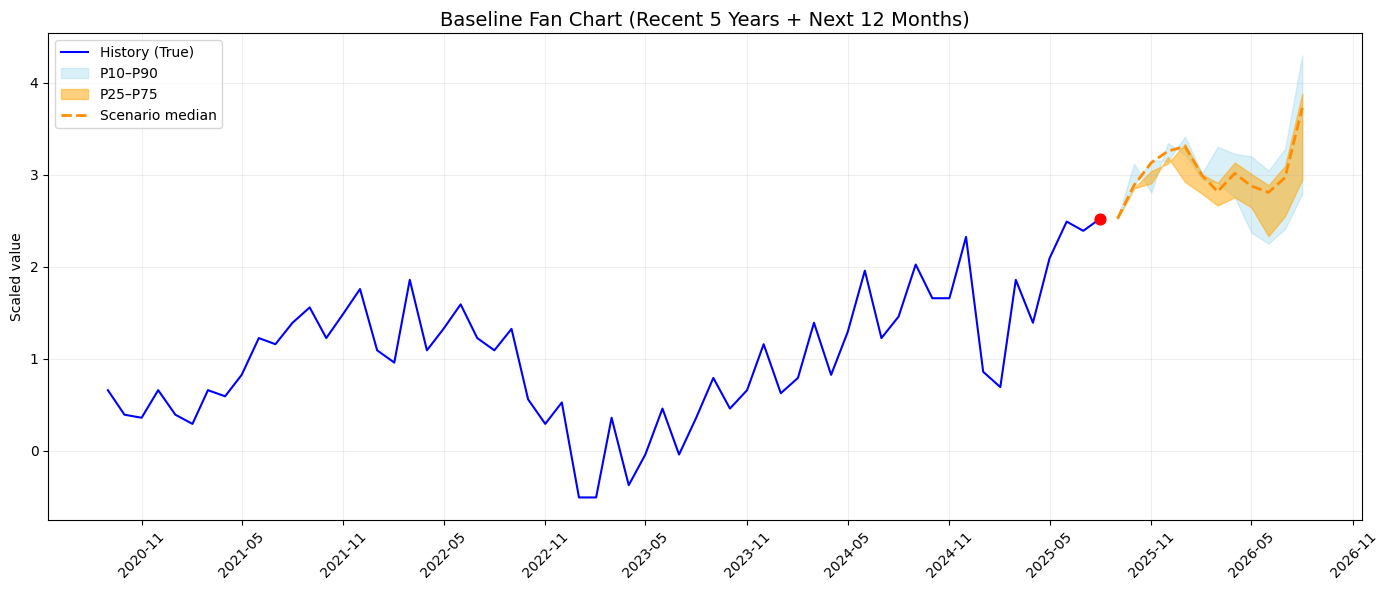

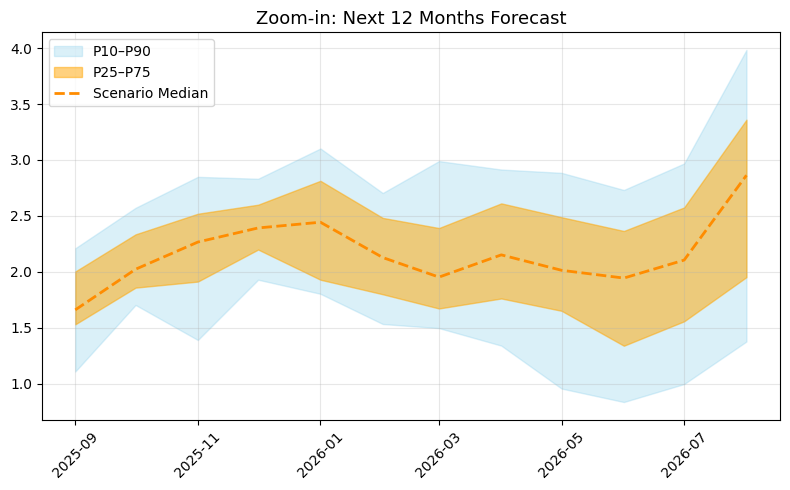

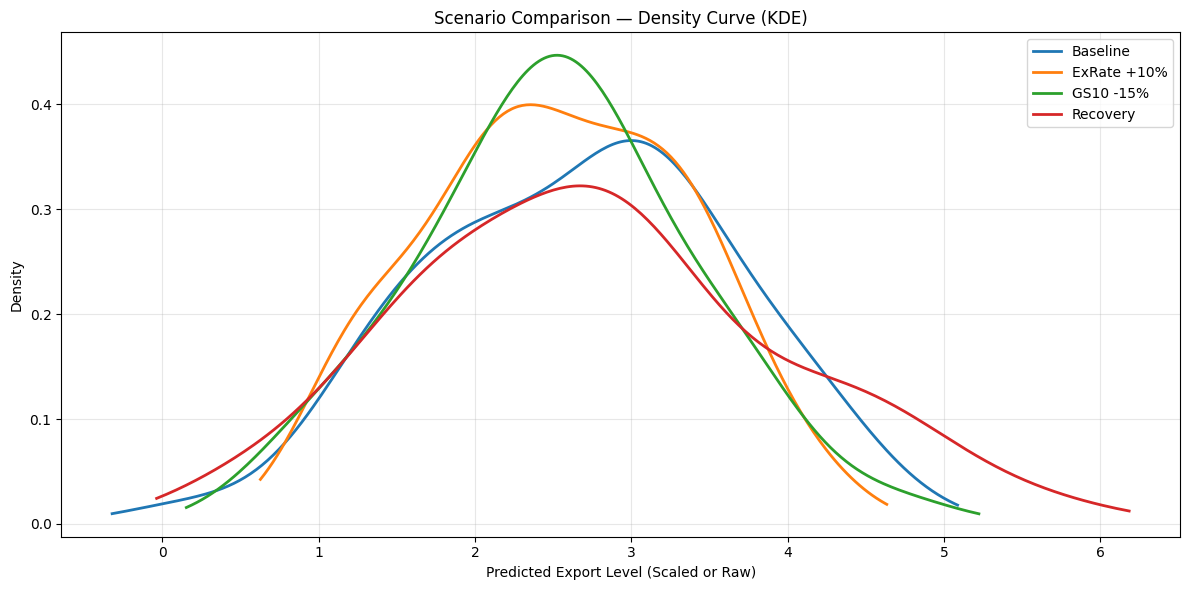


=== Scenario Mean / Std / Quantile Table ===
   Scenario  Mean (μ)  Std (σ)       5%      95%
   Baseline  2.661107 0.958588 1.215650 4.130479
ExRate +10%  2.527292 0.804528 1.209608 3.694957
  GS10 -15%  2.516348 0.858403 1.047635 3.796057
   Recovery  2.758405 1.170920 0.938624 4.720729
=========== Completed 1st! ===========
=== Point Forecast Metrics ===
MSE : 0.14455856382846832
MAE : 0.15621089935302734
RMSE : 0.3802085816860199


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


=== Probabilistic (Student-t) Metrics ===
NLL_mean: -0.538720428943634
NLL_std : 0.3141025900840759
=== Coverage / Sharpness ===
Coverage_80%: 0.7500
Sharpness_80%: 1.5228
=== CRPS ===
CRPS_mean: 0.4084
CRPS_per_h: [0.1853 0.2614 0.3688 0.0872 1.2281 1.1374 0.1487 0.4772 0.1811 0.3379
 0.2157 0.272 ]
=== Risk Metrics ===
P_up: 0.88
P_tail(<-10.0%): 0.04
VaR_10%: -0.020178241655230522
ES_10%: -0.11576437950134277
[LAST] ||mu_q-mu_p||_2 = 0.07988537847995758
[LAST] mean(std_q) = 0.5468100905418396
[LAST] posterior(z=mu_q): df median=8.07 (p10=5.94, p90=9.99) | scale median=0.1155 (p10=0.0449, p90=0.3643)
[LAST] prior(z=mu_p): df median=8.07 (p10=5.94, p90=10.00) | scale median=0.1151 (p10=0.0448, p90=0.3638)
[LAST] NLL using z=mu_q: -0.5231 | using z=mu_p: -0.5195
========== ARIMA Baseline ==========


c:\Users\AN\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\AN\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\AN\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA RMSE : 0.9511
ARIMA NLL  : 8.8329
ARIMA CRPS : 0.7695
ARIMA Coverage_80% : 0.2665
ARIMA Sharpness_80% : 0.6854
========== LSTM Rolling-Forward Baseline ==========
[LSTM train ep 1] loss=0.8188
[LSTM train ep 10] loss=0.3841
[LSTM train ep 20] loss=0.2868
[LSTM train ep 30] loss=0.2275
[LSTM train ep 40] loss=0.1571
[LSTM train ep 50] loss=0.1140
LSTM (rolling) RMSE : 0.3282
LSTM (rolling) NLL  : 0.3047
LSTM (rolling) CRPS : 0.1807
CRPS_per_h: [0.1673 0.168  0.1638 0.1648 0.1665 0.1735 0.1763 0.1809 0.1791 0.1938
 0.2071 0.2274]
LSTM Coverage_80%  : 0.8245
LSTM Sharpness_80% : 0.8410
========== Train Vanilla cVAE ==========
[weak cVAE 010] loss=-0.0906
[weak cVAE 020] loss=-0.5187
[weak cVAE 030] loss=-0.7944
[weak cVAE 040] loss=-0.9643
[weak cVAE 050] loss=-1.0879
[weak cVAE 060] loss=-1.1698
[weak cVAE 070] loss=-1.2356
[weak cVAE 080] loss=-1.2899
[weak cVAE 090] loss=-1.3537
[weak cVAE 100] loss=-1.4519
[weak cVAE 110] loss=-1.4208
[weak cVAE 120] loss=-1.5062
[weak cVAE 130]

In [ ]:
# ===========================================
# main.py — 전체 파이프라인 실행 (
# ===========================================
import torch
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

from data_train import (
    preprocess,
    train_model,
    rolling_backtest,
    rolling_forward_test,
)

from scenario_eval import (
    evaluate_model,
    scenario_predict_local,

    plot_forecast_zoom,
    plot_baseline_fanchart_recent,
    plot_kde_with_stats,

    compute_point_forecast_metrics,
    compute_coverage_and_sharpness,
    compute_crps_from_samples,
    evaluate_student_t_nll,
    compute_risk_metrics
)

# -------------------------------
# Hyperparameters
# -------------------------------
L = 36
H = 12

LATENT_DIM = 32
COND_DIM = 6
HIDDEN = 128

BETA = 1.0
LR = 1e-3
EPOCHS = 150
BATCH_SIZE = 32

DEVICE = "cuda"

MACRO_HIDDEN_DIM = 128
MACRO_LATENT_DIM = 32

# -------------------------------
# Condition columns (raw)
# -------------------------------
condition_raw_cols = [
    "Exchange Rate",
    "CAPEX",
    "PMI",
    "CLI",
    "ISM",
    "GS10" 
]

MACRO_COLS = [
    "PMI",
    "GS10",
    "M2SL",
    "UNRATE",
    "CPIAUCSL",
    "INDPRO",
]


def _clean_numeric_series(s: pd.Series) -> pd.Series:
    # "1,388.90" 같은 문자열/공백 안전 처리
    return pd.to_numeric(s.astype(str).str.replace(",", "").str.strip(), errors="coerce")


def make_scaled_condition_vector(
    *,
    last_truth_raw: pd.Series,
    scenario_cond_raw: dict,
    df_scaled: pd.DataFrame,
    scaler,
    condition_raw_cols: list,
) -> np.ndarray:
    """
    preprocess와 동일한 규칙(숫자 coercion + CAPEX log1p)로
    raw scenario row -> scaled row -> condition vector를 만든다.
    - feature-name warning 제거 (DataFrame으로 transform)
    - object dtype 제거
    - CAPEX 변환 불일치 버그 제거
    """
    cols = list(df_scaled.columns)

    # last row를 dict로 만들고 scenario 값으로 overwrite
    row = last_truth_raw.to_dict()
    row.update(scenario_cond_raw)

    # scaler가 fit된 컬럼 순서로 DataFrame 구성
    row_df = pd.DataFrame([row], columns=cols)

    # numeric coercion
    row_df = row_df.apply(_clean_numeric_series, axis=0).fillna(0.0)

    # preprocess와 동일: CAPEX log1p(음수 방어)
    if "CAPEX" in row_df.columns:
        cap = row_df["CAPEX"].to_numpy(dtype=np.float64)
        cap = np.clip(cap, 0.0, None)
        row_df["CAPEX"] = np.log1p(cap)

    scaled_full = scaler.transform(row_df)[0]

    cond_vec = np.array(
        [scaled_full[cols.index(col)] for col in condition_raw_cols],
        dtype=np.float32,
    )
    return cond_vec


# ===========================================
# Main
# ===========================================
if __name__ == "__main__":

    print("========== 1) Preprocessing ==========")

    X, Y, C, scaler, df_raw, df_scaled, macro_feature_indices = preprocess(
        csv_path="data.csv",
        macro_csv_path="macro.csv",
        condition_raw_cols=condition_raw_cols,
        macro_cols=MACRO_COLS,
        L=L,
        H=H,
    )

    print("X:", X.shape, "Y:", Y.shape, "C:", C.shape)
    print("======================================\n")

    # =======================================
    # 2) Train model
    # =======================================
    print("========== 2) Training ==========")

    model = train_model(
        X, Y, C,
        latent_dim=LATENT_DIM,
        cond_dim=COND_DIM,
        hidden=HIDDEN,
        H_len=H,
        beta=BETA,
        lr=LR,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        device=DEVICE,
        macro_feature_indices=macro_feature_indices,
        macro_latent_dim=MACRO_LATENT_DIM,
        macro_hidden_dim=MACRO_HIDDEN_DIM,
    )

    print("=================================\n")

    # =======================================
    # 5) Posterior Evaluation
    # =======================================
    print("========== 5) Posterior Evaluation ==========")

    preds, trues, mse_eval = evaluate_model(
        model_path="timevae_ctvae_prior.pth",
        X=X, Y=Y, C=C,
        latent_dim=LATENT_DIM,
        cond_dim=COND_DIM,
        hidden=HIDDEN,
        H=H,
        beta=BETA,
        macro_feature_indices=macro_feature_indices,
        macro_hidden_dim=MACRO_HIDDEN_DIM,
        macro_latent_dim=MACRO_LATENT_DIM,
        device=DEVICE
    )

    print(f"Posterior Recon MSE: {mse_eval:.6f}")
    print("=================================\n")

    # =======================================
    # 6) Scenario Generation
    # =======================================
    print("========== 6) Scenario Forecasting ==========")

    # 실제 마지막 month의 RAW 값
    last_truth_raw = df_raw.iloc[-1]
    print("===== Last RAW sample =====")
    print(last_truth_raw)

    # 시나리오 조건 (RAW 형태)
    scenario_cond_raw = {
        "Exchange Rate": 1388.91,
        "CAPEX": 93163.0,
        "PMI": 48.0,
        "CLI": 100.27,
        "ISM": 51.4,
        "GS10": 4.26
    }

    

    scenario_cond_scaled = make_scaled_condition_vector(
        last_truth_raw=last_truth_raw,
        scenario_cond_raw=scenario_cond_raw,
        df_scaled=df_scaled,
        scaler=scaler,
        condition_raw_cols=condition_raw_cols,
    )

    # 시나리오 샘플링
    scenario_samples = scenario_predict_local(
        model_path="timevae_ctvae_prior.pth",
        X_last=X[-1],
        cond_true=C[-1],
        cond_scenario=scenario_cond_scaled,
        latent_dim=LATENT_DIM,
        cond_dim=COND_DIM,
        hidden=HIDDEN,
        H=H,
        beta=BETA,
        num_samples=50,
        z_shrink=0.5,
        macro_feature_indices=macro_feature_indices,
        macro_hidden_dim=MACRO_HIDDEN_DIM,
        macro_latent_dim=MACRO_LATENT_DIM,
        device=DEVICE
    )

    ##시나리오 1
    scenario_cond_raw = {
        "Exchange Rate": 1527.8,
        "CAPEX": 93163.0,
        "PMI": 48.0,
        "CLI": 100.27,
        "ISM": 51.4,
        "GS10": 4.26
    }

    scenario_cond_scaled = make_scaled_condition_vector(
        last_truth_raw=last_truth_raw,
        scenario_cond_raw=scenario_cond_raw,
        df_scaled=df_scaled,
        scaler=scaler,
        condition_raw_cols=condition_raw_cols,
    )

    scenario_samples_1 = scenario_predict_local(
        model_path="timevae_ctvae_prior.pth",
        X_last=X[-1],
        cond_true=C[-1],
        cond_scenario=scenario_cond_scaled,
        latent_dim=LATENT_DIM,
        cond_dim=COND_DIM,
        hidden=HIDDEN,
        H=H,
        beta=BETA,
        num_samples=50,
        z_shrink=0.5,
        macro_feature_indices=macro_feature_indices,
        macro_hidden_dim=MACRO_HIDDEN_DIM,
        macro_latent_dim=MACRO_LATENT_DIM,
        device=DEVICE
    )

    ##시나리오 2
    scenario_cond_raw = {
        "Exchange Rate": 1388.91,
        "CAPEX": 93163.0,
        "PMI": 48.0,
        "CLI": 100.27,
        "ISM": 51.4,
        "GS10": 3.6
    }

    scenario_cond_scaled = make_scaled_condition_vector(
        last_truth_raw=last_truth_raw,
        scenario_cond_raw=scenario_cond_raw,
        df_scaled=df_scaled,
        scaler=scaler,
        condition_raw_cols=condition_raw_cols,
    )

    scenario_samples_2 = scenario_predict_local(
        model_path="timevae_ctvae_prior.pth",
        X_last=X[-1],
        cond_true=C[-1],
        cond_scenario=scenario_cond_scaled,
        latent_dim=LATENT_DIM,
        cond_dim=COND_DIM,
        hidden=HIDDEN,
        H=H,
        beta=BETA,
        num_samples=50,
        z_shrink=0.5,
        macro_feature_indices=macro_feature_indices,
        macro_hidden_dim=MACRO_HIDDEN_DIM,
        macro_latent_dim=MACRO_LATENT_DIM,
        device=DEVICE
    )

    ##시나리오 3
    scenario_cond_raw = {
        "Exchange Rate": 1300.0,
        "PMI": 55.0,
        "CLI": 102.0,
        "ISM": 55.0,
        "GS10": 3.6
    }

    scenario_cond_scaled = make_scaled_condition_vector(
        last_truth_raw=last_truth_raw,
        scenario_cond_raw=scenario_cond_raw,
        df_scaled=df_scaled,
        scaler=scaler,
        condition_raw_cols=condition_raw_cols,
    )

    scenario_samples_3 = scenario_predict_local(
        model_path="timevae_ctvae_prior.pth",
        X_last=X[-1],
        cond_true=C[-1],
        cond_scenario=scenario_cond_scaled,
        latent_dim=LATENT_DIM,
        cond_dim=COND_DIM,
        hidden=HIDDEN,
        H=H,
        beta=BETA,
        num_samples=50,
        z_shrink=0.5,
        macro_feature_indices=macro_feature_indices,
        macro_hidden_dim=MACRO_HIDDEN_DIM,
        macro_latent_dim=MACRO_LATENT_DIM,
        device=DEVICE
    )



    # =======================================
    # 7) Fan Chart 출력
    # =======================================
    print("========== 7) Plotting Fan Chart ==========")

    plot_baseline_fanchart_recent(
        true_seq_full=df_scaled.values,
        pred_seq_last=preds[-1],
        scenario_samples=scenario_samples,
        df_index=df_scaled.index,
        feature_index=0,
        history=60
    )

    plot_forecast_zoom(
        pred_seq_last=preds[-1],              # 마지막 chunk 12개월 예측
        scenario_samples=scenario_samples,    # baseline scenario or custom scenario
        df_index=df_scaled.index,             # 날짜 index
        feature_index=0                       # 첫 번째 feature (exports)
    )



    scenario_samples_dict = {
        "Baseline": scenario_samples,
        "ExRate +10%": scenario_samples_1,
        "GS10 -15%": scenario_samples_2,
        "Recovery": scenario_samples_3
    }

    plot_kde_with_stats(scenario_samples_dict)






    print("=========== Completed 1st! ===========")

    # =======================================
    # Metrics
    # =======================================
    point_metrics = compute_point_forecast_metrics(preds, trues)
    print("=== Point Forecast Metrics ===")
    for k, v in point_metrics.items():
        print(f"{k} : {v}")

    # ✅ FIXED: NLL eval should match macro_feature_indices too
    nll_metrics = evaluate_student_t_nll(
        model_path="timevae_ctvae_prior.pth",
        X=X,
        Y=Y,
        C=C,
        latent_dim=LATENT_DIM,
        cond_dim=COND_DIM,
        hidden=HIDDEN,
        H=H,
        beta=BETA,
        macro_feature_indices=macro_feature_indices,
        macro_hidden_dim=MACRO_HIDDEN_DIM,
        macro_latent_dim=MACRO_LATENT_DIM,
        device=DEVICE
    )

    print("=== Probabilistic (Student-t) Metrics ===")
    print("NLL_mean:", nll_metrics["NLL_mean"])
    print("NLL_std :", nll_metrics["NLL_std"])

    coverage = compute_coverage_and_sharpness(
        scenario_samples,
        true_future=Y[-1],
        feature_index=0,
        lower_q=10,
        upper_q=90
    )

    print("=== Coverage / Sharpness ===")
    for k, v in coverage.items():
        print(f"{k}: {float(v):.4f}")

    crps = compute_crps_from_samples(
        scenario_samples,
        true_future=Y[-1],
        feature_index=0
    )

    print("=== CRPS ===")
    print(f"CRPS_mean: {crps['CRPS_mean']:.4f}")
    print("CRPS_per_h:", np.round(crps["CRPS_per_h"], 4))

    current_level_scaled = X[-1][-1, :]  # scaled current level

    risk = compute_risk_metrics(
        scenario_samples=scenario_samples,
        current_level_scaled=current_level_scaled,
        scaler=scaler,
        feature_index=0,
        horizon_idx=-1,
        tail_threshold_raw=-0.10,
        alpha=0.10
    )

    print("=== Risk Metrics ===")
    for k, v in risk.items():
        print(f"{k}: {v}")

     
        
def debug_last_step_distribution(model, X, C, macro_feature_indices, Y=None, tag=""):
    device = next(model.parameters()).device
    x = torch.tensor(X[-1:]).float().to(device)          # (1,L,D)
    c = torch.tensor(C[-1:]).float().to(device)          # (1,cond_dim)
    macro_x = x[:, :, macro_feature_indices].permute(0, 2, 1)  # (1,macro_dim,L)

    with torch.no_grad():
        mu_q, logvar_q = model.encoder(x, c)
        zq = mu_q
        mean_q, dist_q = model.decoder(zq, c)

        # prior 쪽도 비교(shift가 먹는지)
        z_macro_out = model.macro_encoder(macro_x)
        z_macro = z_macro_out[0] if isinstance(z_macro_out, (tuple, list)) else z_macro_out
        mu_p, logvar_p = model.prior(c, z_macro)
        zp = mu_p
        mean_p, dist_p = model.decoder(zp, c)

        def _stat(name, dist):
            df = dist.df.detach().cpu().numpy().ravel()
            sc = dist.scale.detach().cpu().numpy().ravel()
            print(f"[{tag}] {name}: df median={np.median(df):.2f} (p10={np.percentile(df,10):.2f}, p90={np.percentile(df,90):.2f}) | "
                  f"scale median={np.median(sc):.4f} (p10={np.percentile(sc,10):.4f}, p90={np.percentile(sc,90):.4f})")

        print(f"[{tag}] ||mu_q-mu_p||_2 =", float(torch.norm(mu_q - mu_p, p=2)))
        print(f"[{tag}] mean(std_q) =", float(torch.exp(0.5*logvar_q).mean()))
        _stat("posterior(z=mu_q)", dist_q)
        _stat("prior(z=mu_p)", dist_p)

        if Y is not None:
            y = torch.tensor(Y[-1:]).float().to(device)
            nll_q = -dist_q.log_prob(y).mean().item()
            nll_p = -dist_p.log_prob(y).mean().item()
            print(f"[{tag}] NLL using z=mu_q: {nll_q:.4f} | using z=mu_p: {nll_p:.4f}")

debug_last_step_distribution(model, X, C, macro_feature_indices, Y=Y, tag="LAST")



# =======================================
# ARIMA Baseline
# =======================================
print("========== ARIMA Baseline ==========")

from baseline_arima import arima_baseline

arima_res = arima_baseline(
    X=X,
    Y=Y,
    target_index=0,
    L=L,
    H=H
)

print(f"ARIMA RMSE : {arima_res['RMSE']:.4f}")
print(f"ARIMA NLL  : {arima_res['NLL']:.4f}")
print(f"ARIMA CRPS : {arima_res['CRPS']:.4f}")
print(f"ARIMA Coverage_80% : {arima_res['Coverage_80%']:.4f}")
print(f"ARIMA Sharpness_80% : {arima_res['Sharpness_80%']:.4f}")

print("====================================")

# =======================================
# LSTM Baseline
# ======================================
from baseline_lstm_rolling import train_lstm_once, rolling_forward_lstm

print("========== LSTM Rolling-Forward Baseline ==========")

lstm_model = train_lstm_once(
    X=X,
    Y=Y,
    target_index=0,
    H=H,
    hidden=64,
    layers=2,
    device=DEVICE,
    epochs=50
)

lstm_res = rolling_forward_lstm(
    lstm_model,
    X=X,
    Y=Y,
    target_index=0,
    H=H
)

print(f"LSTM (rolling) RMSE : {lstm_res['RMSE']:.4f}")
print(f"LSTM (rolling) NLL  : {lstm_res['NLL_mean']:.4f}")
print(f"LSTM (rolling) CRPS : {lstm_res['CRPS_mean']:.4f}")
print("CRPS_per_h:", np.round(lstm_res['CRPS_per_h'], 4))
print(f"LSTM Coverage_80%  : {lstm_res['Coverage_80%']:.4f}")
print(f"LSTM Sharpness_80% : {lstm_res['Sharpness_80%']:.4f}")


        
from baseline_cvae_vanilla import (
    train_model_vanilla,
    rolling_forward_cvae
)

print("========== Train Vanilla cVAE ==========")
train_model_vanilla(
    X, Y, C,
    latent_dim=LATENT_DIM,
    cond_dim=COND_DIM,
    hidden=HIDDEN,
    H_len=H,
    L=L,
    lr=LR,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    beta=BETA,
    device=DEVICE,
    save_path="cvae_vanilla.pth"
)

print("========== Evaluate Vanilla cVAE ==========")
res_cvae = rolling_forward_cvae(
    model_path="cvae_vanilla.pth",
    X=X, Y=Y, C=C,
    latent_dim=LATENT_DIM,
    cond_dim=COND_DIM,
    hidden=HIDDEN,
    H=H,
    L=L,
    beta=BETA,
    device=DEVICE
)
    
print("========== Vanilla cVAE Baseline ==========")
print(f"RMSE          : {res_cvae['RMSE']:.4f}")
print(f"NLL_mean      : {res_cvae['NLL_mean']:.4f}")
print(f"CRPS_mean     : {res_cvae['CRPS_mean']:.4f}")
print(f"Coverage_80%  : {res_cvae['Coverage_80%']:.4f}")
print(f"Sharpness_80% : {res_cvae['Sharpness_80%']:.4f}")
print("CVaR_10%     :", res_cvae["CVaR_10%"])

In [8]:
# ===========================================
# train_ablation_models.py
# CT-VAE Ablation Training (5 models)
# - full_ct_vae
# - no_student_t
# - no_macro_prior
# - no_film
# - no_decomp
# ===========================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from model import Encoder, Decoder, ConditionalPrior, TimeVAE
from macro_pretrain import MacroEncoder
from data_train import preprocess


# -------------------------------
# Ablation Variant Modules
# -------------------------------

class EncoderNoFiLM(Encoder):
    """
    FiLM + TCN 대신, input_proj + 평균 pooling만 사용하는 간단 Encoder
    (아키텍처는 달라져도, 입력/출력 shape는 동일하게 유지)
    """
    def __init__(self, x_dim, c_dim, h_dim, z_dim):
        super().__init__(x_dim, c_dim, h_dim, z_dim)
        # FiLM_TCN을 안 쓸 것이므로 덮어쓰기
        self.tcn_film = None

    def forward(self, x, c):
        # x: (B, L, x_dim), c: (B, c_dim)
        x = x.permute(0, 2, 1)        # (B, x_dim, L)
        h = self.input_proj(x)        # (B, hidden, L)

        # cond embedding 써도 되고/안 써도 되지만, 간단히 mean pooling만 적용
        h_mean = h.mean(dim=-1)       # (B, hidden)

        mu = self.mu_layer(h_mean)
        logvar = self.logvar_layer(h_mean)
        return mu, logvar


class DecoderGaussian(Decoder):
    """
    Student-t 대신 Gaussian likelihood 사용.
    나머지 구조는 동일.
    """
    def forward(self, z, c):
        mean, dist_student = super().forward(z, c)
        scale = dist_student.scale
        dist = torch.distributions.Normal(loc=mean, scale=scale)
        return mean, dist


class DecoderNoDecomp(Decoder):
    """
    Trend + Seasonality 제거, Residual RNN만 사용하는 Decoder.
    (out_dim, H, hidden 등 shape는 원본과 동일하게 유지)
    """
    def forward(self, z, c):
        device = z.device
        B = z.size(0)
        D = self.out_dim

        # context
        x = torch.cat([z, c], dim=-1)          # (B, latent+cond)
        h = self.fc_context(x)                 # (B, hidden)

        # Residual RNN만 사용
        rnn_input = h.unsqueeze(1).repeat(1, self.H, 1)  # (B,H,hidden)
        rnn_out, _ = self.rnn(rnn_input)                # (B,H,hidden)
        mean = self.rnn_out(rnn_out)                    # (B,H,D)

        # scale / df 모수는 원본 구조 그대로 사용
        scale = nn.functional.softplus(self.fc_scale(h)).view(B, self.H, D) + 1e-4
        df    = nn.functional.softplus(self.fc_df(h)).view(B, self.H, D) + 2.0

        dist = torch.distributions.StudentT(df, loc=mean, scale=scale)
        return mean, dist


class PriorNoMacro(nn.Module):
    """
    macro z 없이, condition c만 사용하는 prior p(z|c).
    """
    def __init__(self, cond_dim, latent_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(cond_dim, hidden),
            nn.ReLU(),
            nn.LayerNorm(hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.mu_head = nn.Linear(hidden, latent_dim)
        self.logvar_head = nn.Linear(hidden, latent_dim)

    def forward(self, c):
        h = self.net(c)
        return self.mu_head(h), self.logvar_head(h)


class TimeVAENoMacroPrior(TimeVAE):
    """
    macro_encoder 및 z_macro 없이 prior p(z|c)만 사용하는 TimeVAE.
    model.py의 TimeVAE를 상속하지만 forward를 override.
    """
    def __init__(self, encoder, decoder, prior, latent_dim, beta=1.0):
        # macro_encoder=None으로 고정
        super().__init__(encoder, decoder, prior, macro_encoder=None, latent_dim=latent_dim, beta=beta)

    def forward(self, x, c, macro_x=None, y=None, use_prior_sampling_if_no_y=True):
        # 1) posterior q(z|x,c)
        mu_q, logvar_q = self.encoder(x, c)

        # 2) prior p(z|c)
        mu_p, logvar_p = self.prior(c)

        # 3) inference 모드
        if (y is None) and use_prior_sampling_if_no_y:
            z = self.reparameterize(mu_p, logvar_p)
            mean, dist = self.decoder(z, c)
            return mean, z, (mu_p, logvar_p)

        # 4) 학습 모드: posterior 사용
        z = self.reparameterize(mu_q, logvar_q)
        mean, dist = self.decoder(z, c)

        log_prob = dist.log_prob(y)
        recon = -log_prob.mean()

        kl = self.kl_gaussian(mu_q, logvar_q, mu_p, logvar_p)
        loss = recon + self.beta * kl

        return loss, recon, kl, mean, z, (mu_p, logvar_p)


# -------------------------------
# Model Builders (train/eval 공통)
# -------------------------------

def build_full(out_dim, cond_dim, latent_dim, hidden, H, macro_latent_dim, device):
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
    prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

    macro_encoder = MacroEncoder(
        input_dim=6,
        hidden_dim=128,
        latent_dim=macro_latent_dim
    ).to(device)
    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    model = TimeVAE(
        encoder=encoder,
        decoder=decoder,
        prior=prior,
        macro_encoder=macro_encoder,
        latent_dim=latent_dim,
        beta=1.0
    ).to(device)
    return model


def build_no_student_t(out_dim, cond_dim, latent_dim, hidden, H, macro_latent_dim, device):
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = DecoderGaussian(latent_dim, cond_dim, out_dim, hidden, H).to(device)
    prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

    macro_encoder = MacroEncoder(
        input_dim=6,
        hidden_dim=128,
        latent_dim=macro_latent_dim
    ).to(device)
    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    model = TimeVAE(
        encoder=encoder,
        decoder=decoder,
        prior=prior,
        macro_encoder=macro_encoder,
        latent_dim=latent_dim,
        beta=1.0
    ).to(device)
    return model


def build_no_film(out_dim, cond_dim, latent_dim, hidden, H, macro_latent_dim, device):
    encoder = EncoderNoFiLM(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
    prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

    macro_encoder = MacroEncoder(
        input_dim=6,
        hidden_dim=128,
        latent_dim=macro_latent_dim
    ).to(device)
    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    model = TimeVAE(
        encoder=encoder,
        decoder=decoder,
        prior=prior,
        macro_encoder=macro_encoder,
        latent_dim=latent_dim,
        beta=1.0
    ).to(device)
    return model


def build_no_decomp(out_dim, cond_dim, latent_dim, hidden, H, macro_latent_dim, device):
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = DecoderNoDecomp(latent_dim, cond_dim, out_dim, hidden, H).to(device)
    prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

    macro_encoder = MacroEncoder(
        input_dim=6,
        hidden_dim=128,
        latent_dim=macro_latent_dim
    ).to(device)
    macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
    macro_encoder.eval()
    for p in macro_encoder.parameters():
        p.requires_grad = False

    model = TimeVAE(
        encoder=encoder,
        decoder=decoder,
        prior=prior,
        macro_encoder=macro_encoder,
        latent_dim=latent_dim,
        beta=1.0
    ).to(device)
    return model


def build_no_macro_prior(out_dim, cond_dim, latent_dim, hidden, H, macro_latent_dim, device):
    encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
    decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
    prior   = PriorNoMacro(cond_dim, latent_dim, hidden).to(device)

    model = TimeVAENoMacroPrior(
        encoder=encoder,
        decoder=decoder,
        prior=prior,
        latent_dim=latent_dim,
        beta=1.0
    ).to(device)
    return model


# -------------------------------
# Training Loop
# -------------------------------

def train_single_model(model, X, Y, C, macro_feature_indices, device, epochs=100, batch_size=32, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    N = len(X)
    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for i in range(0, N, batch_size):
            x_batch = torch.tensor(X[i:i+batch_size]).float().to(device)
            y_batch = torch.tensor(Y[i:i+batch_size]).float().to(device)
            c_batch = torch.tensor(C[i:i+batch_size]).float().to(device)

            if model.macro_encoder is not None:
                macro_x_batch = x_batch[:, :, macro_feature_indices].permute(0, 2, 1)
            else:
                macro_x_batch = None

            loss, recon, kl, _, _, _ = model(
                x_batch,
                c_batch,
                macro_x_batch,
                y=y_batch,
                use_prior_sampling_if_no_y=False
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {ep:03d}] Loss = {total_loss:.4f}")

    return model


# -------------------------------
# Main
# -------------------------------

def run_all_ablation():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Hyperparameters (기존 프로젝트와 동일하게 맞춰야 함)
    L = 36
    H = 12
    LATENT_DIM = 32
    HIDDEN = 128
    MACRO_HIDDEN_DIM = 128
    MACRO_LATENT_DIM = 32

    condition_raw_cols = ["Exchange Rate", "CAPEX", "PMI", "CLI", "ISM"]
    macro_cols = ["PMI", "GS10", "M2SL", "UNRATE", "CPIAUCSL", "INDPRO"]

    X, Y, C, scaler, df_raw, df_scaled, macro_feature_indices = preprocess(
        csv_path="data.csv",
        macro_csv_path="macro.csv",
        condition_raw_cols=condition_raw_cols,
        macro_cols=macro_cols,
        L=L,
        H=H
    )

    out_dim = X.shape[-1]
    cond_dim = C.shape[-1]

    configs = {
        "full_ct_vae":      build_full,
        "no_student_t":     build_no_student_t,
        "no_macro_prior":   build_no_macro_prior,
        "no_film":          build_no_film,
        "no_decomp":        build_no_decomp,
    }

    for name, builder in configs.items():
        print("\n====================================")
        print(f"Training Ablation Model: {name}")
        print("====================================")

        model = builder(
            out_dim=out_dim,
            cond_dim=cond_dim,
            latent_dim=LATENT_DIM,
            hidden=HIDDEN,
            H=H,
            macro_latent_dim=MACRO_LATENT_DIM,
            device=device
        )

        model = train_single_model(
            model,
            X, Y, C,
            macro_feature_indices=macro_feature_indices,
            device=device,
            epochs=100,          # 필요하면 늘려
            batch_size=32,
            lr=1e-3
        )

        save_path = f"{name}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Saved: {save_path}")


if __name__ == "__main__":
    run_all_ablation()


X shape: (141, 36, 12)
Y shape: (141, 12, 12)
C shape: (141, 5)
macro_feature_indices: [6, 7, 8, 9, 10, 11]

Training Ablation Model: full_ct_vae


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Epoch 001] Loss = 15.0092
[Epoch 002] Loss = 10.8125
[Epoch 003] Loss = 8.0720
[Epoch 004] Loss = 7.2600
[Epoch 005] Loss = 6.6144
[Epoch 006] Loss = 6.2290
[Epoch 007] Loss = 5.8421
[Epoch 008] Loss = 5.5365
[Epoch 009] Loss = 5.3730
[Epoch 010] Loss = 5.0025
[Epoch 011] Loss = 4.8436
[Epoch 012] Loss = 4.5950
[Epoch 013] Loss = 4.4688
[Epoch 014] Loss = 4.2299
[Epoch 015] Loss = 4.2061
[Epoch 016] Loss = 3.9611
[Epoch 017] Loss = 3.9566
[Epoch 018] Loss = 3.8024
[Epoch 019] Loss = 3.7026
[Epoch 020] Loss = 3.4126
[Epoch 021] Loss = 3.5083
[Epoch 022] Loss = 3.2904
[Epoch 023] Loss = 3.3350
[Epoch 024] Loss = 3.2349
[Epoch 025] Loss = 3.1349
[Epoch 026] Loss = 3.0025
[Epoch 027] Loss = 2.8399
[Epoch 028] Loss = 2.9317
[Epoch 029] Loss = 2.7395
[Epoch 030] Loss = 2.8132
[Epoch 031] Loss = 2.7734
[Epoch 032] Loss = 2.6055
[Epoch 033] Loss = 2.3972
[Epoch 034] Loss = 2.4900
[Epoch 035] Loss = 2.3820
[Epoch 036] Loss = 2.6214
[Epoch 037] Loss = 2.2363
[Epoch 038] Loss = 2.4687
[Epoch 039

In [9]:
# ===========================================
# ablation_experiment.py
# Evaluate Ablation Models:
# - Posterior MSE / MAE / RMSE
# - NLL (reconstruction loss)
# - CRPS
# - Coverage / Sharpness (80% interval)
# - Risk Metrics (P_up, P_tail, VaR, ES)
# ===========================================

import torch
import numpy as np
import pandas as pd

from model import Encoder, Decoder, ConditionalPrior, TimeVAE
from macro_pretrain import MacroEncoder
from data_train import preprocess
from train_ablation_models import (
    EncoderNoFiLM, DecoderGaussian, DecoderNoDecomp,
    PriorNoMacro, TimeVAENoMacroPrior
)


# -------------------------------
# Metric Utils
# -------------------------------

def compute_point_forecast_metrics(preds, trues):
    preds = np.array(preds)
    trues = np.array(trues)

    diff = preds - trues
    mse = float(np.mean(diff ** 2))
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(mse))

    return {"MSE": mse, "MAE": mae, "RMSE": rmse}


def compute_coverage_and_sharpness(
    scenario_samples,
    true_future,
    feature_index=0,
    lower_q=10,
    upper_q=90
):
    scenario_samples = np.array(scenario_samples)
    true_future = np.array(true_future)

    lower = np.percentile(scenario_samples[:, :, feature_index], lower_q, axis=0)
    upper = np.percentile(scenario_samples[:, :, feature_index], upper_q, axis=0)
    true = true_future[:, feature_index]

    inside = (true >= lower) & (true <= upper)
    coverage = float(inside.mean())

    width = upper - lower
    sharpness = float(width.mean())

    return {
        "coverage": coverage,
        "sharpness": sharpness
    }


def compute_crps_from_samples(scenario_samples, true_future, feature_index=0):
    S = np.array(scenario_samples)[:, :, feature_index]  # (M,H)
    y = np.array(true_future)[:, feature_index]          # (H,)

    M, H = S.shape

    term1 = np.mean(np.abs(S - y[None, :]), axis=0)      # (H,)

    S1 = S[:, None, :]
    S2 = S[None, :, :]
    term2 = np.mean(np.abs(S1 - S2), axis=(0, 1))        # (H,)

    crps_per_h = term1 - 0.5 * term2
    crps = float(crps_per_h.mean())

    return {
        "CRPS_mean": crps,
        "CRPS_per_h": crps_per_h
    }


def compute_risk_metrics(
    scenario_samples,
    current_level_scaled,
    scaler,
    feature_index=0,
    horizon_idx=-1,
    tail_threshold_raw=-0.10,
    alpha=0.10
):
    scenario_samples = np.array(scenario_samples)
    M, H, D = scenario_samples.shape

    future_scaled = scenario_samples[:, horizon_idx, :]  # (M,D)
    future_raw = scaler.inverse_transform(future_scaled)[:, feature_index]

    current_raw = scaler.inverse_transform(
        np.array(current_level_scaled).reshape(1, -1)
    )[0, feature_index]

    ret = (future_raw - current_raw) / current_raw

    p_up = float(np.mean(ret > 0.0))
    p_tail = float(np.mean(ret < tail_threshold_raw))

    var_alpha = float(np.quantile(ret, alpha))
    tail = ret[ret <= var_alpha]
    if len(tail) < 3:
        es_alpha = var_alpha
    else:
        es_alpha = float(tail.mean())

    return {
        "P_up": p_up,
        "P_tail": p_tail,
        "VaR_10%": var_alpha,
        "ES_10%": es_alpha
    }


# -------------------------------
# Model Builder (eval용, train과 동일)
# -------------------------------

def build_model_for_name(name,
                         out_dim, cond_dim,
                         latent_dim, hidden, H,
                         macro_latent_dim,
                         macro_feature_indices,
                         device):

    if name == "full_ct_vae":
        encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
        decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
        prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

        macro_encoder = MacroEncoder(
            input_dim=6,
            hidden_dim=128,
            latent_dim=macro_latent_dim
        ).to(device)
        macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
        macro_encoder.eval()
        for p in macro_encoder.parameters():
            p.requires_grad = False

        model = TimeVAE(
            encoder=encoder,
            decoder=decoder,
            prior=prior,
            macro_encoder=macro_encoder,
            latent_dim=latent_dim,
            beta=1.0
        ).to(device)
        ckpt_path = "full_ct_vae.pth"

    elif name == "no_student_t":
        encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
        decoder = DecoderGaussian(latent_dim, cond_dim, out_dim, hidden, H).to(device)
        prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

        macro_encoder = MacroEncoder(
            input_dim=6,
            hidden_dim=128,
            latent_dim=macro_latent_dim
        ).to(device)
        macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
        macro_encoder.eval()
        for p in macro_encoder.parameters():
            p.requires_grad = False

        model = TimeVAE(
            encoder=encoder,
            decoder=decoder,
            prior=prior,
            macro_encoder=macro_encoder,
            latent_dim=latent_dim,
            beta=1.0
        ).to(device)
        ckpt_path = "no_student_t.pth"

    elif name == "no_macro_prior":
        encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
        decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
        prior   = PriorNoMacro(cond_dim, latent_dim, hidden).to(device)

        model = TimeVAENoMacroPrior(
            encoder=encoder,
            decoder=decoder,
            prior=prior,
            latent_dim=latent_dim,
            beta=1.0
        ).to(device)
        ckpt_path = "no_macro_prior.pth"

    elif name == "no_film":
        encoder = EncoderNoFiLM(out_dim, cond_dim, hidden, latent_dim).to(device)
        decoder = Decoder(latent_dim, cond_dim, out_dim, hidden, H).to(device)
        prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

        macro_encoder = MacroEncoder(
            input_dim=6,
            hidden_dim=128,
            latent_dim=macro_latent_dim
        ).to(device)
        macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
        macro_encoder.eval()
        for p in macro_encoder.parameters():
            p.requires_grad = False

        model = TimeVAE(
            encoder=encoder,
            decoder=decoder,
            prior=prior,
            macro_encoder=macro_encoder,
            latent_dim=latent_dim,
            beta=1.0
        ).to(device)
        ckpt_path = "no_film.pth"

    elif name == "no_decomp":
        encoder = Encoder(out_dim, cond_dim, hidden, latent_dim).to(device)
        decoder = DecoderNoDecomp(latent_dim, cond_dim, out_dim, hidden, H).to(device)
        prior   = ConditionalPrior(cond_dim, macro_latent_dim, latent_dim, hidden).to(device)

        macro_encoder = MacroEncoder(
            input_dim=6,
            hidden_dim=128,
            latent_dim=macro_latent_dim
        ).to(device)
        macro_encoder.load_state_dict(torch.load("macro_encoder.pth", map_location=device))
        macro_encoder.eval()
        for p in macro_encoder.parameters():
            p.requires_grad = False

        model = TimeVAE(
            encoder=encoder,
            decoder=decoder,
            prior=prior,
            macro_encoder=macro_encoder,
            latent_dim=latent_dim,
            beta=1.0
        ).to(device)
        ckpt_path = "no_decomp.pth"

    else:
        raise ValueError(f"Unknown ablation name: {name}")

    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    return model


# -------------------------------
# Single Ablation Evaluation
# -------------------------------

def evaluate_ablation_model(
    name,
    X, Y, C,
    macro_feature_indices,
    scaler,
    latent_dim, cond_dim, hidden, H,
    macro_latent_dim,
    device="cuda"
):
    print(f"\n===== Evaluating Ablation: {name} =====")

    out_dim = X.shape[-1]
    model = build_model_for_name(
        name,
        out_dim=out_dim,
        cond_dim=cond_dim,
        latent_dim=latent_dim,
        hidden=hidden,
        H=H,
        macro_latent_dim=macro_latent_dim,
        macro_feature_indices=macro_feature_indices,
        device=device
    )

    preds_list = []
    trues_list = []
    nll_list = []

    with torch.no_grad():
        for i in range(len(X)):
            x = torch.tensor(X[i:i+1]).float().to(device)
            y = torch.tensor(Y[i:i+1]).float().to(device)
            c = torch.tensor(C[i:i+1]).float().to(device)

            if model.macro_encoder is not None:
                macro_x = x[:, :, macro_feature_indices].permute(0, 2, 1)
            else:
                macro_x = None

            loss, recon, kl, mean, _, _ = model(
                x, c, macro_x,
                y=y,
                use_prior_sampling_if_no_y=False
            )

            preds_list.append(mean.cpu().numpy())
            trues_list.append(y.cpu().numpy())
            nll_list.append(recon.item())

    preds = np.concatenate(preds_list, axis=0)
    trues = np.concatenate(trues_list, axis=0)

    point_metrics = compute_point_forecast_metrics(preds, trues)
    nll_mean = float(np.mean(nll_list))

    # -------- Scenario Sampling (posterior 주변) --------
    with torch.no_grad():
        x_last = torch.tensor(X[-1:]).float().to(device)
        y_last = torch.tensor(Y[-1:]).float().to(device)
        c_last = torch.tensor(C[-1:]).float().to(device)

        if model.macro_encoder is not None:
            macro_x_last = x_last[:, :, macro_feature_indices].permute(0, 2, 1)
        else:
            macro_x_last = None

        # posterior q(z|x,c)
        mu_q, logvar_q = model.encoder(x_last, c_last)
        std_q = torch.exp(0.5 * logvar_q)

        num_samples = 50
        samples = []

        for _ in range(num_samples):
            eps = torch.randn_like(std_q)
            z = mu_q + std_q * eps
            mean_future, dist_future = model.decoder(z, c_last)
            y_scen = dist_future.rsample()
            samples.append(y_scen.squeeze(0).cpu().numpy())

    scenario_samples = np.stack(samples, axis=0)   # (M,H,D)

    cov = compute_coverage_and_sharpness(
        scenario_samples,
        true_future=Y[-1],
        feature_index=0,
        lower_q=10,
        upper_q=90
    )

    crps = compute_crps_from_samples(
        scenario_samples,
        true_future=Y[-1],
        feature_index=0
    )

    risk = compute_risk_metrics(
        scenario_samples=scenario_samples,
        current_level_scaled=X[-1][-1],
        scaler=scaler,
        feature_index=0,
        horizon_idx=-1,
        tail_threshold_raw=-0.10,
        alpha=0.10
    )

    return {
        "MSE": point_metrics["MSE"],
        "MAE": point_metrics["MAE"],
        "RMSE": point_metrics["RMSE"],
        "NLL": nll_mean,
        "CRPS": crps["CRPS_mean"],
        "Coverage80": cov["coverage"],
        "Sharpness": cov["sharpness"],
        "P_up": risk["P_up"],
        "P_tail": risk["P_tail"],
        "VaR_10%": risk["VaR_10%"],
        "ES_10%": risk["ES_10%"],
    }


# -------------------------------
# Main
# -------------------------------

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    L = 36
    H = 12
    LATENT_DIM = 32
    HIDDEN = 128
    MACRO_LATENT_DIM = 32

    condition_raw_cols = ["Exchange Rate", "CAPEX", "PMI", "CLI", "ISM"]
    macro_cols = ["PMI", "GS10", "M2SL", "UNRATE", "CPIAUCSL", "INDPRO"]

    X, Y, C, scaler, df_raw, df_scaled, macro_feature_indices = preprocess(
        csv_path="data.csv",
        macro_csv_path="macro.csv",
        condition_raw_cols=condition_raw_cols,
        macro_cols=macro_cols,
        L=L,
        H=H
    )

    cond_dim = C.shape[-1]

    model_names = [
        "full_ct_vae",
        "no_student_t",
        "no_macro_prior",
        "no_film",
        "no_decomp",
    ]

    results = {}
    for name in model_names:
        results[name] = evaluate_ablation_model(
            name=name,
            X=X, Y=Y, C=C,
            macro_feature_indices=macro_feature_indices,
            scaler=scaler,
            latent_dim=LATENT_DIM,
            cond_dim=cond_dim,
            hidden=HIDDEN,
            H=H,
            macro_latent_dim=MACRO_LATENT_DIM,
            device=device
        )

    df_res = pd.DataFrame(results).T
    print("\n\n===== Final Ablation Summary =====")
    print(df_res.to_string(float_format=lambda x: f"{x: .4f}"))

X shape: (141, 36, 12)
Y shape: (141, 12, 12)
C shape: (141, 5)
macro_feature_indices: [6, 7, 8, 9, 10, 11]

===== Evaluating Ablation: full_ct_vae =====


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



===== Evaluating Ablation: no_student_t =====


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



===== Evaluating Ablation: no_macro_prior =====


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



===== Evaluating Ablation: no_film =====


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



===== Evaluating Ablation: no_decomp =====


C:\Users\AN\AppData\Roaming\Python\Python313\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)




===== Final Ablation Summary =====
                   MSE     MAE    RMSE     NLL    CRPS  Coverage80  Sharpness    P_up  P_tail  VaR_10%  ES_10%
full_ct_vae     0.2374  0.2519  0.4873  0.0604  0.4891      0.2500     1.2916  0.7000  0.0800  -0.0826 -0.1510
no_student_t    0.2029  0.2537  0.4504  0.1027  0.4439      0.5833     1.4069  0.7200  0.0800  -0.0907 -0.1494
no_macro_prior  0.2222  0.2407  0.4714  0.0203  0.4319      0.5833     1.3749  0.7600  0.0800  -0.0845 -0.1530
no_film         0.2323  0.2529  0.4819  0.0562  0.4619      0.5000     1.2715  0.7600  0.0600  -0.0830 -0.1090
no_decomp       0.2412  0.2471  0.4912 -0.0634  0.4561      0.4167     1.3471  0.5800  0.2000  -0.2243 -0.2526


In [ ]:
# baseline_arima.py
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm

# -------------------------------
# Gaussian NLL
# -------------------------------
def nll_gaussian(y, mu, sigma):
    eps = 1e-6
    return 0.5 * np.log(2*np.pi*(sigma**2) + eps) + \
           0.5 * ((y - mu)**2) / (sigma**2 + eps)

# -------------------------------
# Gaussian CRPS
# -------------------------------
def crps_gaussian(y, mu, sigma):
    z = (y - mu) / sigma
    return sigma * (z * (2*norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1/np.sqrt(np.pi))

# -------------------------------
# Coverage / Sharpness
# -------------------------------
def gaussian_coverage_and_sharpness(y_true, mu, sigma, lower_q=10, upper_q=90):
    """
    y_true: (H,)
    mu    : (H,)
    sigma : scalar
    """
    z_low = norm.ppf(lower_q / 100.0)
    z_up  = norm.ppf(upper_q / 100.0)

    lower = mu + sigma * z_low
    upper = mu + sigma * z_up

    inside = (y_true >= lower) & (y_true <= upper)
    coverage = inside.mean()

    sharpness = (upper - lower).mean()

    return coverage, sharpness

# -------------------------------
# ARIMA Baseline (Rolling-forward)
# -------------------------------
def arima_baseline(X, Y, target_index=0, L=36, H=12):
    """
    X: (N, L, D)
    Y: (N, H, D)
    """
    N = X.shape[0]

    # 전체 target 시계열
    full_series = np.concatenate([
        X[:, -1, target_index],
        Y[-1, :, target_index]
    ])

    preds_all = []
    rmse_list = []
    nll_list = []
    crps_list = []

    coverage_list = []
    sharpness_list = []

    for i in range(N):
        train_data = full_series[:(i + L)]

        model = ARIMA(train_data, order=(1,1,1)).fit()

        sigma = np.std(model.resid) + 1e-6   # residual std

        pred = model.forecast(H)             # (H,)
        preds_all.append(pred)

        y_true = Y[i, :, target_index]

        # RMSE
        rmse_list.append(np.sqrt(np.mean((y_true - pred)**2)))

        # NLL
        nll_list.append(np.mean(nll_gaussian(y_true, pred, sigma)))

        # CRPS
        crps_list.append(np.mean(crps_gaussian(y_true, pred, sigma)))

        # Coverage + Sharpness
        cov_i, sharp_i = gaussian_coverage_and_sharpness(
            y_true=y_true,
            mu=pred,
            sigma=sigma,
            lower_q=10,
            upper_q=90
        )
        coverage_list.append(cov_i)
        sharpness_list.append(sharp_i)

    return {
        "preds": np.array(preds_all),      # (N, H)
        "RMSE": float(np.mean(rmse_list)),
        "NLL": float(np.mean(nll_list)),
        "CRPS": float(np.mean(crps_list)),
        "Coverage_80%": float(np.mean(coverage_list)),
        "Sharpness_80%": float(np.mean(sharpness_list)),
    }


In [11]:
# baseline_cvae_vanilla_weak.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
from scipy.stats import norm


###############################################
# Dataset
###############################################
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y, c):
        self.x = x
        self.y = y
        self.c = c
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.c[idx]


###############################################
# Encoder (weak version)
###############################################
class Encoder(nn.Module):
    def __init__(self, x_dim, cond_dim, hidden, latent_dim, L):
        super().__init__()
        self.L = L
        self.x_dim = x_dim

        self.fc1 = nn.Linear(L * x_dim + cond_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)

        self.mu = nn.Linear(hidden, latent_dim)
        self.logvar = nn.Linear(hidden, latent_dim)

    def forward(self, x, c):
        B, L, D = x.shape
        x_flat = x.reshape(B, L * D)

        # --- condition dropout (약화 요소 1) ---
        c = F.dropout(c, p=0.2, training=self.training)

        inp = torch.cat([x_flat, c], dim=1)

        h = F.relu(self.fc1(inp))
        h = F.relu(self.fc2(h))

        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar


###############################################
# Conditional Prior (unchanged)
###############################################
class ConditionalPrior(nn.Module):
    def __init__(self, cond_dim, hidden, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.mu = nn.Linear(hidden, latent_dim)
        self.logvar = nn.Linear(hidden, latent_dim)

    def forward(self, c):
        h = F.relu(self.fc1(c))
        h = F.relu(self.fc2(h))
        return self.mu(h), self.logvar(h)


###############################################
# Decoder (weak variance)
###############################################
class Decoder(nn.Module):
    def __init__(self, latent_dim, cond_dim, hidden, H, D):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + cond_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.mu = nn.Linear(hidden, H * D)
        self.logvar = nn.Linear(hidden, H * D)

        self.H = H
        self.D = D

    def forward(self, z, c):
        inp = torch.cat([z, c], dim=1)
        h = F.relu(self.fc1(inp))
        h = F.relu(self.fc2(h))

        mu = self.mu(h).reshape(-1, self.H, self.D)
        logvar = self.logvar(h).reshape(-1, self.H, self.D)

        # --- variance noise (약화 요소 2) ---
        var = torch.exp(logvar) + 1e-3

        return mu, var


###############################################
# Full Vanilla cVAE
###############################################
class CVAE(nn.Module):
    def __init__(self, x_dim, cond_dim, latent_dim, hidden, H, D, L):
        super().__init__()
        self.encoder = Encoder(x_dim, cond_dim, hidden, latent_dim, L)
        self.prior = ConditionalPrior(cond_dim, hidden, latent_dim)
        self.decoder = Decoder(latent_dim, cond_dim, hidden, H, D)

    def forward(self, x, c):
        mu_q, logvar_q = self.encoder(x, c)
        std_q = torch.exp(0.5 * logvar_q)
        eps = torch.randn_like(std_q)
        z = mu_q + eps * std_q

        mu_p, logvar_p = self.prior(c)
        mu_dec, var_dec = self.decoder(z, c)

        return mu_dec, var_dec, mu_q, logvar_q, mu_p, logvar_p


###############################################
# Train Vanilla cVAE (weak)
###############################################
def train_model_vanilla(
    X, Y, C,
    latent_dim, cond_dim, hidden,
    H_len, L, lr, epochs, batch_size, beta,
    device="cuda",
    save_path="cvae_vanilla_weak.pth"
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    N, L_, D = X.shape

    model = CVAE(
        x_dim=D,
        cond_dim=cond_dim,
        latent_dim=latent_dim,
        hidden=hidden,
        H=H_len,
        D=D,
        L=L
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    ds = TimeSeriesDataset(X, Y, C)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    # KL divergence
    def kl(mu_q, logvar_q, mu_p, logvar_p):
        return 0.5 * torch.mean(
            logvar_p - logvar_q +
            (torch.exp(logvar_q) + (mu_q - mu_p)**2) / torch.exp(logvar_p) - 1
        )

    model.train()
    for ep in range(1, epochs+1):
        total = 0
        for x, y, c in dl:
            x = x.float().to(device)
            y = y.float().to(device)
            c = c.float().to(device)

            opt.zero_grad()
            mu_dec, var_dec, mu_q, logvar_q, mu_p, logvar_p = model(x, c)

            recon = 0.5 * (torch.log(var_dec) + (y - mu_dec)**2 / var_dec)
            recon = recon.mean()
            kl_loss = kl(mu_q, logvar_q, mu_p, logvar_p)

            loss = recon + beta * kl_loss
            loss.backward()
            opt.step()

            total += loss.item()

        if ep % 10 == 0:
            print(f"[weak cVAE {ep:03d}] loss={total/len(dl):.4f}")

    torch.save(model.state_dict(), save_path)
    return model


###############################################
# CVaR helper
###############################################
def compute_cvar(return_samples, alpha=0.10):
    """
    CVaR(alpha): return <= VaR(alpha)의 평균
    return_samples: (M,) numpy array
    """
    var_alpha = np.quantile(return_samples, alpha)
    tail = return_samples[return_samples <= var_alpha]
    if tail.size == 0:
        return float(var_alpha)
    return float(tail.mean())


###############################################
# Rolling-Forward Evaluation (weak cVAE)
###############################################
def rolling_forward_cvae(
    model_path,
    X, Y, C,
    latent_dim, cond_dim, hidden,
    H, L, beta,
    device="cuda",
    num_samples=500,
    feature_index=0,
    alpha_cvar=0.10,
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    N, L_, D = X.shape

    model = CVAE(
        x_dim=D, cond_dim=cond_dim, latent_dim=latent_dim, hidden=hidden,
        H=H, D=D, L=L
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds, trues = [], []
    nlls, crps_list = [], []
    coverage_list, sharpness_list = [], []

    cvar_10 = None  # 마지막 anchor에서만 계산

    for i in range(N):
        x = torch.tensor(X[i:i+1], dtype=torch.float32, device=device)
        y = torch.tensor(Y[i:i+1], dtype=torch.float32, device=device)
        c = torch.tensor(C[i:i+1], dtype=torch.float32, device=device)

        with torch.no_grad():
            mu_dec, var_dec, mu_q, logvar_q, _, _ = model(x, c)

        p = mu_dec.cpu().numpy()[0]        # (H, D)
        v = var_dec.cpu().numpy()[0]
        sigma = np.sqrt(v)
        t = y.cpu().numpy()[0]

        preds.append(p)
        trues.append(t)

        # ---------- NLL ----------
        nll = 0.5 * (np.log(2 * np.pi * sigma**2) + (t - p)**2 / (sigma**2))
        nlls.append(float(np.mean(nll)))

        # ---------- CRPS ----------
        z = (t - p) / sigma
        crps = sigma * (
            z * (2 * norm.cdf(z) - 1) +
            2 * norm.pdf(z) - 1 / np.sqrt(np.pi)
        )
        crps_list.append(np.mean(crps))

        # ---------- Coverage 80% ----------
        z_low = norm.ppf(0.10)
        z_up  = norm.ppf(0.90)

        lower = p + sigma * z_low
        upper = p + sigma * z_up

        inside = (t >= lower) & (t <= upper)
        coverage_list.append(float(inside.mean()))

        sharpness_list.append(float((upper - lower).mean()))

        # ---------- CVaR_10% (마지막 anchor에서만) ----------
        if i == N - 1:
            M = int(num_samples)
            # Gaussian 시나리오 샘플링: (M,H,D)
            eps = np.random.randn(M, H, D)
            y_samples = p[None, :, :] + eps * sigma[None, :, :]

            # 마지막 horizon, 선택 feature
            y_last = y_samples[:, -1, feature_index]   # (M,)

            current = X[i, -1, feature_index]          # scaled current level
            returns = (y_last / current) - 1.0         # (M,)

            cvar_10 = compute_cvar(returns, alpha=alpha_cvar)

    preds = np.array(preds)
    trues = np.array(trues)

    rmse = float(np.sqrt(np.mean((preds - trues)**2)))

    return {
        "preds": preds,
        "trues": trues,
        "RMSE": rmse,
        "NLL_mean": float(np.mean(nlls)),
        "CRPS_mean": float(np.mean(crps_list)),
        "Coverage_80%": float(np.mean(coverage_list)),
        "Sharpness_80%": float(np.mean(sharpness_list)),
        "CVaR_10%": cvar_10,
    }


In [12]:
# baseline_lstm_rolling.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm


########################################
# Dataset
########################################
class LSTMDataset(Dataset):
    def __init__(self, X, Y, target_index=0):
        self.X = X[:, :, target_index:target_index+1]
        self.Y = Y[:, :, target_index:target_index+1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


########################################
# Model
########################################
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, layers=2, H=12):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, H)

    def forward(self, x):
        out, _ = self.lstm(x)         # (B, L, H)
        last = out[:, -1, :]          # (B, hidden)
        y = self.fc(last)             # (B, H)
        return y.unsqueeze(-1)        # (B, H, 1)


########################################
# 1) train_lstm_once (main.py에서 요구)
########################################
def train_lstm_once(
    X, Y,
    target_index=0,
    H=12,
    hidden=64,
    layers=2,
    device="cuda",
    epochs=50,
    batch_size=32
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    ds = LSTMDataset(X, Y, target_index)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    model = LSTMForecaster(1, hidden, layers, H).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for ep in range(1, epochs+1):
        total = 0
        for xb, yb in dl:
            xb = xb.float().to(device)
            yb = yb.float().to(device)

            optim.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optim.step()

            total += loss.item()

        if ep % 10 == 0 or ep == 1:
            print(f"[LSTM train ep {ep}] loss={total/len(dl):.4f}")

    return model


########################################
# 2) rolling_forward_lstm (probabilistic)
########################################
def rolling_forward_lstm(
    model,
    X, Y,
    target_index=0,
    H=12,
    num_samples=500,
    lower_q=10,
    upper_q=90
):
    device = next(model.parameters()).device

    N = X.shape[0]
    preds = []
    trues = []

    # Residual 저장 → sigma 추정
    all_resid = []

    # 1차 패스: deterministic 예측
    for i in range(N):
        x_i = torch.tensor(X[i:i+1, :, target_index:target_index+1],
                           dtype=torch.float32, device=device)
        y_i = Y[i, :, target_index]      # (H,)

        with torch.no_grad():
            pred = model(x_i).cpu().numpy()[0, :, 0]  # (H,)

        preds.append(pred)
        trues.append(y_i)
        all_resid.extend(list(pred - y_i))

    preds = np.array(preds)
    trues = np.array(trues)

    # sigma (Gaussian assumption)
    sigma = np.std(all_resid) + 1e-6

    # ============================
    # Probabilistic metrics
    # ============================
    nll_list = []
    crps_list = []
    crps_h_list = []
    cov_list = []
    sharp_list = []

    from scipy.stats import norm

    for i in range(N):
        p = preds[i]  # (H,)
        t = trues[i]  # (H,)

        # ---------- NLL ----------
        nll = 0.5*np.log(2*np.pi*(sigma**2)) + 0.5*((t - p)**2)/(sigma**2)
        nll_list.append(nll.mean())

        # ---------- CRPS ----------
        z = (t - p) / sigma
        crps_h = sigma * (z*(2*norm.cdf(z)-1) + 2*norm.pdf(z) - 1/np.sqrt(np.pi))
        crps_list.append(crps_h.mean())
        crps_h_list.append(crps_h)

        # ---------- Coverage & Sharpness ----------
        zL = norm.ppf(lower_q/100)
        zU = norm.ppf(upper_q/100)

        lower = p + sigma*zL
        upper = p + sigma*zU

        inside = (t >= lower) & (t <= upper)
        cov_list.append(inside.mean())
        sharp_list.append((upper - lower).mean())

    # ---------- RMSE ----------
    rmse = np.sqrt(np.mean((preds - trues)**2))

    return {
        "preds": preds,
        "trues": trues,
        "RMSE": float(rmse),
        "NLL_mean": float(np.mean(nll_list)),
        "CRPS_mean": float(np.mean(crps_list)),
        "CRPS_per_h": np.mean(crps_h_list, axis=0),
        "Coverage_80%": float(np.mean(cov_list)),
        "Sharpness_80%": float(np.mean(sharp_list)),
    }
